In [1]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

<IPython.core.display.Javascript object>

Total number of training images = 1946


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


<IPython.core.display.Javascript object>


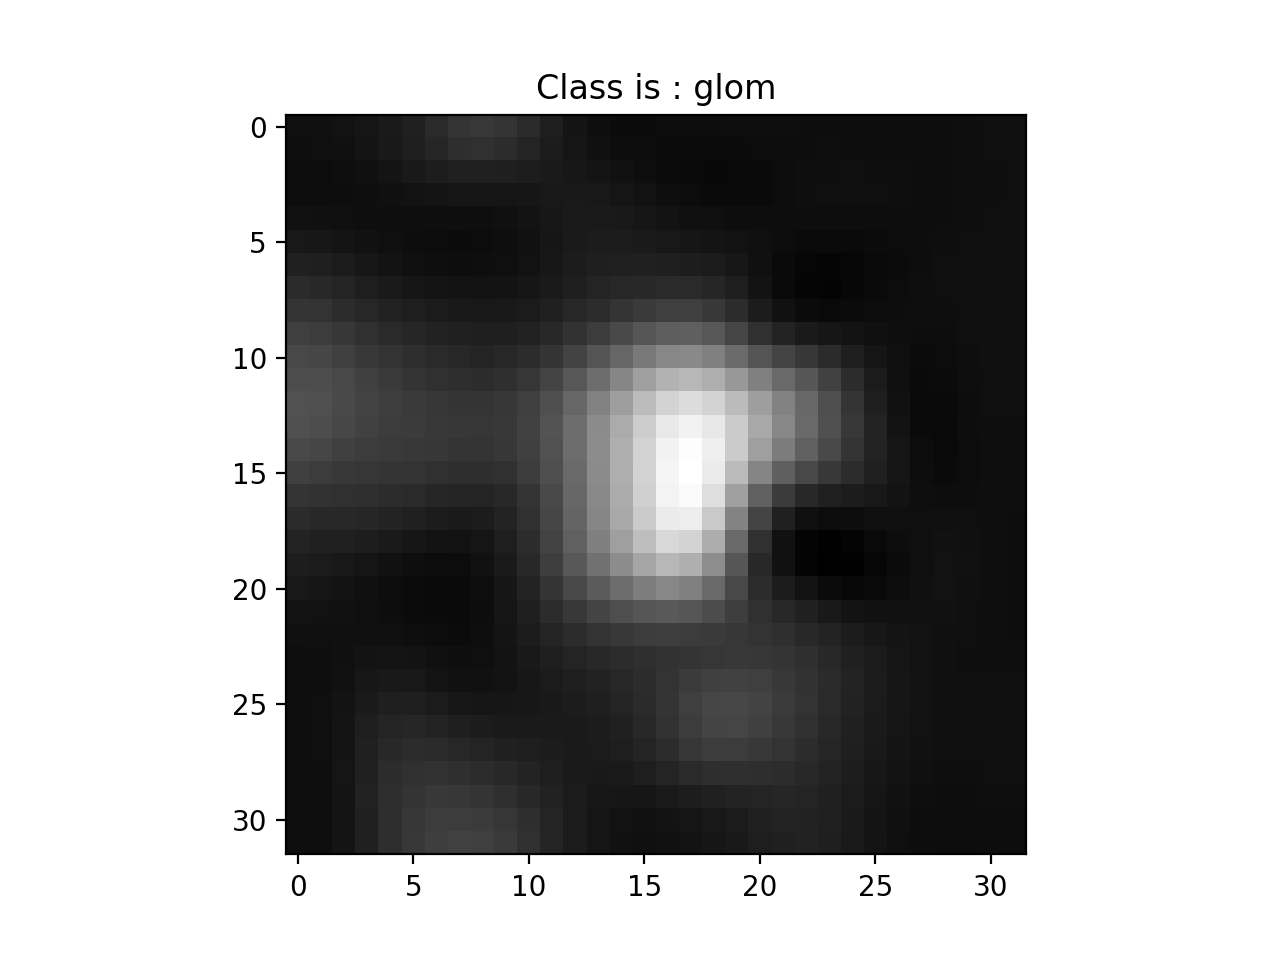

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

In [15]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [2]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [7]:
config_file = '../configs/config_hdf5_rerun.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [ ]:
# Train the network
main(config, None)

Total number of training images = 1946
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

    epoch          : 1
    loss           : 1.001201113829246
    my_metric      : 0.6006883741258741
    f1             : 0.4822285868198231
    balanced_accuracy: 0.5027909122614843
    precision      : 0.5275707741391692
    recall         : 0.6006883741258741
    val_loss       : 1.0317121505737306
    val_my_metric  : 0.6246428571428572
    val_f1         : 0.482184806473205
    val_balanced_accuracy: 0.5
    val_precision  : 0.39413847257653056
    val_recall     : 0.6246428571428572
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 0.9493167583759015
    my_metric      : 0.6021962412587413
    f1             : 0.48548441004784026
    balanced_accuracy: 0.5079187521336584
    precision      : 0.5344760218362582
    recall         : 0.6021962412587413
    val_loss       : 0.739762794971466
    val_my_metric  : 0.6246428571428572
    val_f1         : 0

Model has not improved in -------------| 1 epochs


    epoch          : 5
    loss           : 0.8377048808794755
    my_metric      : 0.6228256118881119
    f1             : 0.5291856617297607
    balanced_accuracy: 0.5354888751663048
    precision      : 0.6403406847917869
    recall         : 0.6228256118881119
    val_loss       : 0.5685528695583344
    val_my_metric  : 0.6527678571428572
    val_f1         : 0.5501927040280222
    val_balanced_accuracy: 0.5437121212121212
    val_precision  : 0.7575178896695289
    val_recall     : 0.6527678571428572
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch5.pth ...
Saving current best: model_best.pth ...
    epoch          : 6
    loss           : 0.7537449621237241
    my_metric      : 0.6408544580419581
    f1             : 0.5612765007744875
    balanced_accuracy: 0.5581882166774771
    precision      : 0.6600522755989223
    recall         : 0.6408544580419581
    val_loss       : 0.5314596772193909
    val_my_metric  : 0.6798214285714286
    va

Model has not improved in -------------| 1 epochs


    epoch          : 9
    loss           : 0.6769708234530228
    my_metric      : 0.6817198426573428
    f1             : 0.63411793372676
    balanced_accuracy: 0.6132702095476202
    precision      : 0.710955188797858
    recall         : 0.6817198426573428
    val_loss       : 0.5965947329998016
    val_my_metric  : 0.6959821428571429
    val_f1         : 0.6331673329825092
    val_balanced_accuracy: 0.6035200748350271
    val_precision  : 0.7358616277790008
    val_recall     : 0.6959821428571429


Model has not improved in -------------| 2 epochs


    epoch          : 10
    loss           : 0.6524192977410096
    my_metric      : 0.6911385489510489
    f1             : 0.6548372982996237
    balanced_accuracy: 0.6342216214658234
    precision      : 0.7165095912339401
    recall         : 0.6911385489510489
    val_loss       : 0.7042229890823364
    val_my_metric  : 0.6882142857142857
    val_f1         : 0.6283395320112913
    val_balanced_accuracy: 0.6033479455055994
    val_precision  : 0.7421990745338736
    val_recall     : 0.6882142857142857


Model has not improved in -------------| 3 epochs


    epoch          : 11
    loss           : 0.6465608901702441
    my_metric      : 0.6996503496503497
    f1             : 0.6708084407889451
    balanced_accuracy: 0.6430429264884816
    precision      : 0.717696475549779
    recall         : 0.6996503496503497
    val_loss       : 0.5305509448051453
    val_my_metric  : 0.7678571428571429
    val_f1         : 0.7572512607252537
    val_balanced_accuracy: 0.7191822389190812
    val_precision  : 0.773206761632444
    val_recall     : 0.7678571428571429


Model has not improved in -------------| 4 epochs


    epoch          : 12
    loss           : 0.6249158164629569
    my_metric      : 0.7173841783216783
    f1             : 0.6890854489560655
    balanced_accuracy: 0.6641419859235018
    precision      : 0.7480224385448626
    recall         : 0.7173841783216783
    val_loss       : 0.501515406370163
    val_my_metric  : 0.7314285714285714
    val_f1         : 0.6992560418506061
    val_balanced_accuracy: 0.6707605170327469
    val_precision  : 0.7754235579235579
    val_recall     : 0.7314285714285714


Model has not improved in -------------| 5 epochs


    epoch          : 13
    loss           : 0.5899839126146756
    my_metric      : 0.7169689685314685
    f1             : 0.6911385636863776
    balanced_accuracy: 0.6649038696030453
    precision      : 0.7402669617695461
    recall         : 0.7169689685314685
    val_loss       : 0.6120428085327149
    val_my_metric  : 0.7183928571428572
    val_f1         : 0.670352754725245
    val_balanced_accuracy: 0.6375436415436415
    val_precision  : 0.7770663132966825
    val_recall     : 0.7183928571428572


Model has not improved in -------------| 6 epochs


    epoch          : 14
    loss           : 0.588448777794838
    my_metric      : 0.7233828671328671
    f1             : 0.6983535792855969
    balanced_accuracy: 0.6709988747313527
    precision      : 0.7424398177089411
    recall         : 0.7233828671328671
    val_loss       : 0.40690134167671205
    val_my_metric  : 0.7875892857142858
    val_f1         : 0.7734043729223128
    val_balanced_accuracy: 0.7468115561315456
    val_precision  : 0.8057896267005848
    val_recall     : 0.7875892857142858
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch14.pth ...
Saving current best: model_best.pth ...
    epoch          : 15
    loss           : 0.5724632820257773
    my_metric      : 0.7305944055944056
    f1             : 0.705231723324893
    balanced_accuracy: 0.6769679680289948
    precision      : 0.7539351007511185
    recall         : 0.7305944055944056
    val_loss       : 0.500518012046814
    val_my_metric  : 0.7303571428571429
    v

Model has not improved in -------------| 1 epochs


    epoch          : 16
    loss           : 0.570939492720824
    my_metric      : 0.7201704545454545
    f1             : 0.6951049640578659
    balanced_accuracy: 0.6688170442613018
    precision      : 0.7409461624060385
    recall         : 0.7201704545454545
    val_loss       : 0.41304770708084104
    val_my_metric  : 0.8203571428571429
    val_f1         : 0.8111006887939481
    val_balanced_accuracy: 0.7841810966810967
    val_precision  : 0.8357340367901476
    val_recall     : 0.8203571428571429


Model has not improved in -------------| 2 epochs


    epoch          : 17
    loss           : 0.589501488667268
    my_metric      : 0.7168706293706294
    f1             : 0.6920335875913319
    balanced_accuracy: 0.6655663755121803
    precision      : 0.733686106707638
    recall         : 0.7168706293706294
    val_loss       : 0.43533791303634645
    val_my_metric  : 0.781875
    val_f1         : 0.7740300016151409
    val_balanced_accuracy: 0.7483423593949909
    val_precision  : 0.7811811718954575
    val_recall     : 0.781875


Model has not improved in -------------| 3 epochs


    epoch          : 18
    loss           : 0.5501234829425812
    my_metric      : 0.7399038461538462
    f1             : 0.7226707501067591
    balanced_accuracy: 0.6955425122108427
    precision      : 0.7567822350820398
    recall         : 0.7399038461538462
    val_loss       : 0.4168228268623352
    val_my_metric  : 0.7792857142857142
    val_f1         : 0.7657092633358438
    val_balanced_accuracy: 0.7287638648739778
    val_precision  : 0.7891063235526551
    val_recall     : 0.7792857142857142


Model has not improved in -------------| 4 epochs


    epoch          : 19
    loss           : 0.5393332380514878
    my_metric      : 0.7420126748251749
    f1             : 0.7232317723615778
    balanced_accuracy: 0.696274819748655
    precision      : 0.7582280967278845
    recall         : 0.7420126748251749
    val_loss       : 0.4286326467990875
    val_my_metric  : 0.7678571428571429
    val_f1         : 0.748138705186814
    val_balanced_accuracy: 0.7145579345611786
    val_precision  : 0.7883029105397525
    val_recall     : 0.7678571428571429


Model has not improved in -------------| 5 epochs


    epoch          : 20
    loss           : 0.5237228858929414
    my_metric      : 0.7537259615384616
    f1             : 0.7370555661201886
    balanced_accuracy: 0.7141286790016663
    precision      : 0.7751525543974348
    recall         : 0.7537259615384616
    val_loss       : 0.4604398846626282
    val_my_metric  : 0.7798214285714286
    val_f1         : 0.7740833565377724
    val_balanced_accuracy: 0.7443359019140896
    val_precision  : 0.7833300572101716
    val_recall     : 0.7798214285714286


Model has not improved in -------------| 6 epochs


    epoch          : 21
    loss           : 0.5141285612032964
    my_metric      : 0.7566324300699301
    f1             : 0.743323680329994
    balanced_accuracy: 0.7183075533075709
    precision      : 0.7712376008720784
    recall         : 0.7566324300699301
    val_loss       : 0.41888070702552793
    val_my_metric  : 0.7975
    val_f1         : 0.7869978254667364
    val_balanced_accuracy: 0.7525808908027471
    val_precision  : 0.8065312434558521
    val_recall     : 0.7975


Model has not improved in -------------| 7 epochs


    epoch          : 22
    loss           : 0.5282425502171884
    my_metric      : 0.7480222902097903
    f1             : 0.7328875449285956
    balanced_accuracy: 0.7073948643601284
    precision      : 0.7673957259936051
    recall         : 0.7480222902097903
    val_loss       : 0.4366204023361206
    val_my_metric  : 0.7808035714285715
    val_f1         : 0.7764813624375486
    val_balanced_accuracy: 0.7479394672679609
    val_precision  : 0.7777477344871615
    val_recall     : 0.7808035714285715


Model has not improved in -------------| 8 epochs


    epoch          : 23
    loss           : 0.5207794583760775
    my_metric      : 0.7441215034965035
    f1             : 0.7272082722808969
    balanced_accuracy: 0.7026617144872606
    precision      : 0.7668145560702292
    recall         : 0.7441215034965035
    val_loss       : 0.47266046404838563
    val_my_metric  : 0.7480357142857142
    val_f1         : 0.7206687768702519
    val_balanced_accuracy: 0.6871360089186176
    val_precision  : 0.7799080636781108
    val_recall     : 0.7480357142857142


Model has not improved in -------------| 9 epochs


    epoch          : 24
    loss           : 0.5316298787410443
    my_metric      : 0.7520323426573428
    f1             : 0.7373180854555502
    balanced_accuracy: 0.7138227034642703
    precision      : 0.7665567108233605
    recall         : 0.7520323426573428
    val_loss       : 0.4623561382293701
    val_my_metric  : 0.8053571428571429
    val_f1         : 0.7946450227464247
    val_balanced_accuracy: 0.7654387571492834
    val_precision  : 0.8170250405126589
    val_recall     : 0.8053571428571429


Model has not improved in -------------| 10 epochs


    epoch          : 25
    loss           : 0.5183791094101392
    my_metric      : 0.7342001748251749
    f1             : 0.7206522886701623
    balanced_accuracy: 0.69619836667108
    precision      : 0.7434223548202851
    recall         : 0.7342001748251749
    val_loss       : 0.43139356970787046
    val_my_metric  : 0.788125
    val_f1         : 0.7683982011659012
    val_balanced_accuracy: 0.7170031502037622
    val_precision  : 0.8102983164496322
    val_recall     : 0.788125


Model has not improved in -------------| 11 epochs


    epoch          : 26
    loss           : 0.4928670067053575
    my_metric      : 0.7470170454545454
    f1             : 0.7314647132210115
    balanced_accuracy: 0.7040474950960932
    precision      : 0.7615674054129135
    recall         : 0.7470170454545454
    val_loss       : 0.3773797392845154
    val_my_metric  : 0.7990178571428571
    val_f1         : 0.7895508009086933
    val_balanced_accuracy: 0.7536604818855273
    val_precision  : 0.811784260561091
    val_recall     : 0.7990178571428571
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch26.pth ...
Saving current best: model_best.pth ...
    epoch          : 27
    loss           : 0.5194078672390717
    my_metric      : 0.7507320804195804
    f1             : 0.7361576852832352
    balanced_accuracy: 0.709146157700996
    precision      : 0.762049481894797
    recall         : 0.7507320804195804
    val_loss       : 0.40092767477035524
    val_my_metric  : 0.8063392857142857
    v

Model has not improved in -------------| 1 epochs


    epoch          : 28
    loss           : 0.49547219620301175
    my_metric      : 0.7754698426573428
    f1             : 0.7645147636454344
    balanced_accuracy: 0.7382334572604076
    precision      : 0.7862698345290309
    recall         : 0.7754698426573428
    val_loss       : 0.44518128633499143
    val_my_metric  : 0.7870535714285715
    val_f1         : 0.7862568319165482
    val_balanced_accuracy: 0.7737372965033704
    val_precision  : 0.7912901025072541
    val_recall     : 0.7870535714285715


Model has not improved in -------------| 2 epochs


    epoch          : 29
    loss           : 0.4926687272695395
    my_metric      : 0.7580310314685315
    f1             : 0.7480138360453866
    balanced_accuracy: 0.7238437940586258
    precision      : 0.7686224947885425
    recall         : 0.7580310314685315
    val_loss       : 0.43738184571266175
    val_my_metric  : 0.7798214285714286
    val_f1         : 0.7726724319651636
    val_balanced_accuracy: 0.7468897793066591
    val_precision  : 0.7831006420252209
    val_recall     : 0.7798214285714286


Model has not improved in -------------| 3 epochs


    epoch          : 30
    loss           : 0.4819125063144244
    my_metric      : 0.7658435314685315
    f1             : 0.7543208851898677
    balanced_accuracy: 0.7303153202696768
    precision      : 0.7790275037869109
    recall         : 0.7658435314685315
    val_loss       : 0.4389000773429871
    val_my_metric  : 0.7845535714285714
    val_f1         : 0.782253856472309
    val_balanced_accuracy: 0.7592275231511711
    val_precision  : 0.7868576915515111
    val_recall     : 0.7845535714285714


Model has not improved in -------------| 4 epochs


    epoch          : 31
    loss           : 0.4993865478497285
    my_metric      : 0.7608500874125874
    f1             : 0.7503888403734007
    balanced_accuracy: 0.7263100521600301
    precision      : 0.7695880380248281
    recall         : 0.7608500874125874
    val_loss       : 0.4310662865638733
    val_my_metric  : 0.7652678571428572
    val_f1         : 0.7549139968785011
    val_balanced_accuracy: 0.729923010486046
    val_precision  : 0.7788125260840748
    val_recall     : 0.7652678571428572


Model has not improved in -------------| 5 epochs


    epoch          : 32
    loss           : 0.5066939661136041
    my_metric      : 0.7483282342657342
    f1             : 0.7371962126915997
    balanced_accuracy: 0.7141719290356883
    precision      : 0.7611826834919513
    recall         : 0.7483282342657342
    val_loss       : 0.3871622681617737
    val_my_metric  : 0.8146428571428572
    val_f1         : 0.813431186304309
    val_balanced_accuracy: 0.7958078757561121
    val_precision  : 0.8139698322510822
    val_recall     : 0.8146428571428572


Model has not improved in -------------| 6 epochs


    epoch          : 33
    loss           : 0.4889763066401848
    my_metric      : 0.7617460664335665
    f1             : 0.7512050244474401
    balanced_accuracy: 0.7283928688007406
    precision      : 0.7721084465314203
    recall         : 0.7617460664335665
    val_loss       : 0.48413040637969973
    val_my_metric  : 0.7594642857142857
    val_f1         : 0.7289326775596361
    val_balanced_accuracy: 0.6750345065562456
    val_precision  : 0.7885714600072221
    val_recall     : 0.7594642857142857


Model has not improved in -------------| 7 epochs


    epoch          : 34
    loss           : 0.5085019308787125
    my_metric      : 0.7512237762237762
    f1             : 0.7400716227743293
    balanced_accuracy: 0.7159997192026837
    precision      : 0.7611432925119707
    recall         : 0.7512237762237762
    val_loss       : 0.4354680240154266
    val_my_metric  : 0.7824107142857143
    val_f1         : 0.7662802166805065
    val_balanced_accuracy: 0.7369135749331588
    val_precision  : 0.8058366976423557
    val_recall     : 0.7824107142857143


Model has not improved in -------------| 8 epochs


    epoch          : 35
    loss           : 0.48645051969931674
    my_metric      : 0.7554414335664336
    f1             : 0.7453488258869243
    balanced_accuracy: 0.7228070616836221
    precision      : 0.7629017497868692
    recall         : 0.7554414335664336
    val_loss       : 0.35506646931171415
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8438343003842741
    val_balanced_accuracy: 0.838987891845792
    val_precision  : 0.853695420958352
    val_recall     : 0.8433035714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch35.pth ...
Saving current best: model_best.pth ...
    epoch          : 36
    loss           : 0.4836685588726631
    my_metric      : 0.775152972027972
    f1             : 0.7648519948064882
    balanced_accuracy: 0.7408487161913483
    precision      : 0.7921908722438649
    recall         : 0.775152972027972
    val_loss       : 0.39537296295166013
    val_my_metric  : 0.8000892857142856
    

Model has not improved in -------------| 1 epochs


    epoch          : 37
    loss           : 0.4891119496180461
    my_metric      : 0.7573426573426574
    f1             : 0.7469111049348658
    balanced_accuracy: 0.7227446980087695
    precision      : 0.7643210216278682
    recall         : 0.7573426573426574
    val_loss       : 0.5207278251647949
    val_my_metric  : 0.7507142857142857
    val_f1         : 0.7210007585184433
    val_balanced_accuracy: 0.6943164888966603
    val_precision  : 0.8145512043597802
    val_recall     : 0.7507142857142857


Model has not improved in -------------| 2 epochs


    epoch          : 38
    loss           : 0.4767246830921907
    my_metric      : 0.7629370629370629
    f1             : 0.7526629728969071
    balanced_accuracy: 0.7303360800724737
    precision      : 0.769089995393511
    recall         : 0.7629370629370629
    val_loss       : 0.39284191727638246
    val_my_metric  : 0.7969642857142858
    val_f1         : 0.794739604872728
    val_balanced_accuracy: 0.769876605426141
    val_precision  : 0.8012702665954846
    val_recall     : 0.7969642857142858


Model has not improved in -------------| 3 epochs


    epoch          : 39
    loss           : 0.5049538532128701
    my_metric      : 0.7549278846153846
    f1             : 0.7441429465127543
    balanced_accuracy: 0.7232516419968675
    precision      : 0.7694254602821484
    recall         : 0.7549278846153846
    val_loss       : 0.38579277992248534
    val_my_metric  : 0.7927678571428571
    val_f1         : 0.7739509660889744
    val_balanced_accuracy: 0.7374211512601605
    val_precision  : 0.8190518304030011
    val_recall     : 0.7927678571428571


Model has not improved in -------------| 4 epochs


    epoch          : 40
    loss           : 0.5035100751198255
    my_metric      : 0.7550371503496505
    f1             : 0.7444721690989973
    balanced_accuracy: 0.7204929943922834
    precision      : 0.7671324386031964
    recall         : 0.7550371503496505
    val_loss       : 0.3732443153858185
    val_my_metric  : 0.8074107142857143
    val_f1         : 0.8010818115628056
    val_balanced_accuracy: 0.7699236417671289
    val_precision  : 0.8090937665562548
    val_recall     : 0.8074107142857143


Model has not improved in -------------| 5 epochs


    epoch          : 41
    loss           : 0.4589345088371864
    my_metric      : 0.7585336538461539
    f1             : 0.7475749377092696
    balanced_accuracy: 0.7227985486931805
    precision      : 0.7700797076036774
    recall         : 0.7585336538461539
    val_loss       : 0.5612392246723175
    val_my_metric  : 0.7360714285714286
    val_f1         : 0.6925474951213865
    val_balanced_accuracy: 0.6530766017608123
    val_precision  : 0.8002115745241888
    val_recall     : 0.7360714285714286


Model has not improved in -------------| 6 epochs


    epoch          : 42
    loss           : 0.4604124977038457
    my_metric      : 0.7662478146853147
    f1             : 0.7549324914752003
    balanced_accuracy: 0.7284244033950587
    precision      : 0.780652250014524
    recall         : 0.7662478146853147
    val_loss       : 0.40430307388305664
    val_my_metric  : 0.8240178571428572
    val_f1         : 0.824578016529701
    val_balanced_accuracy: 0.8214642053800741
    val_precision  : 0.8334225797993465
    val_recall     : 0.8240178571428572


Model has not improved in -------------| 7 epochs


    epoch          : 43
    loss           : 0.45667373217069185
    my_metric      : 0.7674497377622378
    f1             : 0.7571438477247371
    balanced_accuracy: 0.7323665568449509
    precision      : 0.7774747464307711
    recall         : 0.7674497377622378
    val_loss       : 0.38960148096084596
    val_my_metric  : 0.8099999999999999
    val_f1         : 0.8053047941507214
    val_balanced_accuracy: 0.7816468612980241
    val_precision  : 0.8122623653662273
    val_recall     : 0.8099999999999999


Model has not improved in -------------| 8 epochs


    epoch          : 44
    loss           : 0.46422836299125964
    my_metric      : 0.767646416083916
    f1             : 0.7595895602214427
    balanced_accuracy: 0.7403741616751156
    precision      : 0.7804414260077646
    recall         : 0.767646416083916
    val_loss       : 0.4001883089542389
    val_my_metric  : 0.7975
    val_f1         : 0.7952257013968376
    val_balanced_accuracy: 0.7732219460714187
    val_precision  : 0.8006137356369329
    val_recall     : 0.7975


Model has not improved in -------------| 9 epochs


    epoch          : 45
    loss           : 0.44645256721056426
    my_metric      : 0.7801682692307692
    f1             : 0.7718707163832458
    balanced_accuracy: 0.7522271930328167
    precision      : 0.7901532477915789
    recall         : 0.7801682692307692
    val_loss       : 0.39635240435600283
    val_my_metric  : 0.8151785714285713
    val_f1         : 0.8072055599953639
    val_balanced_accuracy: 0.7804805283635652
    val_precision  : 0.8293729069672466
    val_recall     : 0.8151785714285713


Model has not improved in -------------| 10 epochs


    epoch          : 46
    loss           : 0.4623350535447781
    my_metric      : 0.7744536713286714
    f1             : 0.7663300645223138
    balanced_accuracy: 0.7463240231100173
    precision      : 0.784713160362229
    recall         : 0.7744536713286714
    val_loss       : 0.39872419834136963
    val_my_metric  : 0.8042857142857143
    val_f1         : 0.804457394303823
    val_balanced_accuracy: 0.7785759233926128
    val_precision  : 0.8071589909747804
    val_recall     : 0.8042857142857143


Model has not improved in -------------| 11 epochs


    epoch          : 47
    loss           : 0.4554128429064384
    my_metric      : 0.771055506993007
    f1             : 0.7599382168507687
    balanced_accuracy: 0.7349306529211636
    precision      : 0.7829481617337569
    recall         : 0.771055506993007
    val_loss       : 0.42106167078018186
    val_my_metric  : 0.7954464285714286
    val_f1         : 0.7891425127740421
    val_balanced_accuracy: 0.7566263144423935
    val_precision  : 0.8018567892268551
    val_recall     : 0.7954464285714286


Model has not improved in -------------| 12 epochs


    epoch          : 48
    loss           : 0.4541735179149188
    my_metric      : 0.7868771853146852
    f1             : 0.7781991176892227
    balanced_accuracy: 0.7553779469474813
    precision      : 0.7956203389168596
    recall         : 0.7868771853146852
    val_loss       : 0.34580213725566866
    val_my_metric  : 0.8297321428571429
    val_f1         : 0.8231876915847737
    val_balanced_accuracy: 0.7929584689929517
    val_precision  : 0.8380897716694606
    val_recall     : 0.8297321428571429
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch48.pth ...
Saving current best: model_best.pth ...
    epoch          : 49
    loss           : 0.44529893879707044
    my_metric      : 0.7850743006993006
    f1             : 0.777603576407501
    balanced_accuracy: 0.7569813141819198
    precision      : 0.7965236507167709
    recall         : 0.7850743006993006
    val_loss       : 0.38530140519142153
    val_my_metric  : 0.7860714285714285
 

Model has not improved in -------------| 1 epochs


    epoch          : 50
    loss           : 0.47431047833882845
    my_metric      : 0.7611451048951049
    f1             : 0.7512492088420817
    balanced_accuracy: 0.732238652375821
    precision      : 0.774084566979464
    recall         : 0.7611451048951049
    val_loss       : 0.38290712237358093
    val_my_metric  : 0.7923214285714286
    val_f1         : 0.7861127376338133
    val_balanced_accuracy: 0.7588452928007541
    val_precision  : 0.7961931913116123
    val_recall     : 0.7923214285714286


Model has not improved in -------------| 2 epochs


    epoch          : 51
    loss           : 0.4466371284081386
    my_metric      : 0.7875874125874126
    f1             : 0.7799461903553018
    balanced_accuracy: 0.7567010373994877
    precision      : 0.795904485846192
    recall         : 0.7875874125874126
    val_loss       : 0.35389068722724915
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8332387862316899
    val_balanced_accuracy: 0.8093035913035912
    val_precision  : 0.8396983023454971
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 3 epochs


    epoch          : 52
    loss           : 0.4458091167303232
    my_metric      : 0.7749672202797202
    f1             : 0.7657204465422129
    balanced_accuracy: 0.7420712481206574
    precision      : 0.7861855084290721
    recall         : 0.7749672202797202
    val_loss       : 0.37769622802734376
    val_my_metric  : 0.8188392857142857
    val_f1         : 0.8148363621157818
    val_balanced_accuracy: 0.7979670667496755
    val_precision  : 0.8243654557379617
    val_recall     : 0.8188392857142857


Model has not improved in -------------| 4 epochs


    epoch          : 53
    loss           : 0.4503670919399995
    my_metric      : 0.7701486013986014
    f1             : 0.7615278815106369
    balanced_accuracy: 0.7395725418533383
    precision      : 0.7795305607414024
    recall         : 0.7701486013986014
    val_loss       : 0.37811134457588197
    val_my_metric  : 0.7927678571428571
    val_f1         : 0.7831753571839227
    val_balanced_accuracy: 0.754689407724235
    val_precision  : 0.797118244677612
    val_recall     : 0.7927678571428571


Model has not improved in -------------| 5 epochs


    epoch          : 54
    loss           : 0.4680420080056557
    my_metric      : 0.7670563811188812
    f1             : 0.759361825154329
    balanced_accuracy: 0.7385617139247274
    precision      : 0.7803247565715773
    recall         : 0.7670563811188812
    val_loss       : 0.4021732211112976
    val_my_metric  : 0.8042857142857143
    val_f1         : 0.8023398956457651
    val_balanced_accuracy: 0.7942840992881494
    val_precision  : 0.8124036747374388
    val_recall     : 0.8042857142857143


Model has not improved in -------------| 6 epochs


    epoch          : 55
    loss           : 0.4513346472611794
    my_metric      : 0.7595388986013987
    f1             : 0.7511605344590303
    balanced_accuracy: 0.7345141676665091
    precision      : 0.7744948993557066
    recall         : 0.7595388986013987
    val_loss       : 0.4497625887393951
    val_my_metric  : 0.7366071428571429
    val_f1         : 0.7084236147437462
    val_balanced_accuracy: 0.6723553477938287
    val_precision  : 0.7684756320723303
    val_recall     : 0.7366071428571429


Model has not improved in -------------| 7 epochs


    epoch          : 56
    loss           : 0.445345900952816
    my_metric      : 0.772159090909091
    f1             : 0.7642688064507532
    balanced_accuracy: 0.7444559063405196
    precision      : 0.7784780215216571
    recall         : 0.772159090909091
    val_loss       : 0.354094535112381
    val_my_metric  : 0.8063392857142857
    val_f1         : 0.7970246457839616
    val_balanced_accuracy: 0.7630496020035662
    val_precision  : 0.812710356477667
    val_recall     : 0.8063392857142857


Model has not improved in -------------| 8 epochs


    epoch          : 57
    loss           : 0.4258705675601959
    my_metric      : 0.7775677447552448
    f1             : 0.7700658808645785
    balanced_accuracy: 0.7494180338063233
    precision      : 0.7857840111517093
    recall         : 0.7775677447552448
    val_loss       : 0.35452277064323423
    val_my_metric  : 0.8125892857142857
    val_f1         : 0.8033635390573683
    val_balanced_accuracy: 0.7725397335068596
    val_precision  : 0.8233789968654746
    val_recall     : 0.8125892857142857


Model has not improved in -------------| 9 epochs


    epoch          : 58
    loss           : 0.4495673661048596
    my_metric      : 0.7663570804195804
    f1             : 0.7577141108882004
    balanced_accuracy: 0.7390504244465931
    precision      : 0.7793320900164655
    recall         : 0.7663570804195804
    val_loss       : 0.4242470622062683
    val_my_metric  : 0.7901785714285714
    val_f1         : 0.7753599070454043
    val_balanced_accuracy: 0.7386053902873124
    val_precision  : 0.8047669671015258
    val_recall     : 0.7901785714285714


Model has not improved in -------------| 10 epochs


    epoch          : 59
    loss           : 0.47606587409973145
    my_metric      : 0.7625437062937064
    f1             : 0.753478795370638
    balanced_accuracy: 0.7313690587502363
    precision      : 0.7775544885082293
    recall         : 0.7625437062937064
    val_loss       : 0.3974333882331848
    val_my_metric  : 0.7938392857142857
    val_f1         : 0.7841641908857611
    val_balanced_accuracy: 0.7578740384937329
    val_precision  : 0.8160473958333334
    val_recall     : 0.7938392857142857


Model has not improved in -------------| 11 epochs


    epoch          : 60
    loss           : 0.45174268690439373
    my_metric      : 0.7760598776223776
    f1             : 0.7695309566626866
    balanced_accuracy: 0.749296203194999
    precision      : 0.7866888864619958
    recall         : 0.7760598776223776
    val_loss       : 0.3658929347991943
    val_my_metric  : 0.8375892857142857
    val_f1         : 0.8359727124257674
    val_balanced_accuracy: 0.8203993073729915
    val_precision  : 0.8398790532833956
    val_recall     : 0.8375892857142857


Model has not improved in -------------| 12 epochs


    epoch          : 61
    loss           : 0.44691499838462245
    my_metric      : 0.7759724650349651
    f1             : 0.7686313383908543
    balanced_accuracy: 0.7482425454860712
    precision      : 0.7893698912416357
    recall         : 0.7759724650349651
    val_loss       : 0.38646692633628843
    val_my_metric  : 0.8032142857142857
    val_f1         : 0.7948797892347043
    val_balanced_accuracy: 0.7663620497937069
    val_precision  : 0.8087912660434979
    val_recall     : 0.8032142857142857


Model has not improved in -------------| 13 epochs


    epoch          : 62
    loss           : 0.4270437015936925
    my_metric      : 0.7831730769230769
    f1             : 0.7755660097485274
    balanced_accuracy: 0.7543914563477792
    precision      : 0.7924359818594463
    recall         : 0.7831730769230769
    val_loss       : 0.35330581068992617
    val_my_metric  : 0.8141071428571429
    val_f1         : 0.801445694149438
    val_balanced_accuracy: 0.7679748591811159
    val_precision  : 0.8240347921492657
    val_recall     : 0.8141071428571429


Model has not improved in -------------| 14 epochs


    epoch          : 63
    loss           : 0.42808068371736085
    my_metric      : 0.7879807692307692
    f1             : 0.7801939891532108
    balanced_accuracy: 0.7580648831038123
    precision      : 0.7971044580706195
    recall         : 0.7879807692307692
    val_loss       : 0.36379519701004026
    val_my_metric  : 0.8214285714285714
    val_f1         : 0.8195280240598795
    val_balanced_accuracy: 0.8061042302890129
    val_precision  : 0.8338107805584398
    val_recall     : 0.8214285714285714


Model has not improved in -------------| 15 epochs


    epoch          : 64
    loss           : 0.4337812742361656
    my_metric      : 0.780277534965035
    f1             : 0.7726285107441461
    balanced_accuracy: 0.752174102912281
    precision      : 0.7907310851914638
    recall         : 0.780277534965035
    val_loss       : 0.37178738713264464
    val_my_metric  : 0.8104464285714286
    val_f1         : 0.799499331484762
    val_balanced_accuracy: 0.7707675688511741
    val_precision  : 0.8224920169364826
    val_recall     : 0.8104464285714286


Model has not improved in -------------| 16 epochs


    epoch          : 65
    loss           : 0.43900300791630376
    my_metric      : 0.7780703671328671
    f1             : 0.7706477808074911
    balanced_accuracy: 0.7486089530916094
    precision      : 0.7918049606370865
    recall         : 0.7780703671328671
    val_loss       : 0.3815720617771149
    val_my_metric  : 0.8385714285714286
    val_f1         : 0.8403270021135771
    val_balanced_accuracy: 0.8384640426907909
    val_precision  : 0.8475478848816993
    val_recall     : 0.8385714285714286


Model has not improved in -------------| 17 epochs


    epoch          : 66
    loss           : 0.4401884526014328
    my_metric      : 0.7862762237762237
    f1             : 0.780229713459549
    balanced_accuracy: 0.7607578148101923
    precision      : 0.795404430059153
    recall         : 0.7862762237762237
    val_loss       : 0.4082499623298645
    val_my_metric  : 0.8469642857142856
    val_f1         : 0.8453597943032036
    val_balanced_accuracy: 0.8253883592736221
    val_precision  : 0.8495156788011646
    val_recall     : 0.8469642857142856


Model has not improved in -------------| 18 epochs


    epoch          : 67
    loss           : 0.4384376463981775
    my_metric      : 0.7790756118881119
    f1             : 0.77297422548398
    balanced_accuracy: 0.7548985801685337
    precision      : 0.7889771152305574
    recall         : 0.7790756118881119
    val_loss       : 0.41081479787826536
    val_my_metric  : 0.7855357142857142
    val_f1         : 0.7750240267631479
    val_balanced_accuracy: 0.7394836153347623
    val_precision  : 0.7884895431171279
    val_recall     : 0.7855357142857142


Model has not improved in -------------| 19 epochs


    epoch          : 68
    loss           : 0.4512443267382108
    my_metric      : 0.7775677447552448
    f1             : 0.7706511666166729
    balanced_accuracy: 0.7478709816511002
    precision      : 0.7845313426440502
    recall         : 0.7775677447552448
    val_loss       : 0.37528382539749144
    val_my_metric  : 0.8147321428571429
    val_f1         : 0.8129389422509019
    val_balanced_accuracy: 0.7987741884767058
    val_precision  : 0.8166709796803749
    val_recall     : 0.8147321428571429


Model has not improved in -------------| 20 epochs


    epoch          : 69
    loss           : 0.45475779244532955
    my_metric      : 0.7704545454545454
    f1             : 0.7635151691028964
    balanced_accuracy: 0.7464454346209443
    precision      : 0.7839748213296656
    recall         : 0.7704545454545454
    val_loss       : 0.3657368242740631
    val_my_metric  : 0.8033035714285715
    val_f1         : 0.8003679403431814
    val_balanced_accuracy: 0.7803269936143743
    val_precision  : 0.8081955421223513
    val_recall     : 0.8033035714285715


Model has not improved in -------------| 21 epochs


    epoch          : 70
    loss           : 0.42095633997366977
    my_metric      : 0.7827797202797202
    f1             : 0.7754424189167874
    balanced_accuracy: 0.7554537508480799
    precision      : 0.7973137596962131
    recall         : 0.7827797202797202
    val_loss       : 0.3652254819869995
    val_my_metric  : 0.7975
    val_f1         : 0.7894224455158029
    val_balanced_accuracy: 0.7629673725591011
    val_precision  : 0.8060799288430868
    val_recall     : 0.7975


Model has not improved in -------------| 22 epochs


    epoch          : 71
    loss           : 0.4269353850529744
    my_metric      : 0.7890843531468531
    f1             : 0.7829985982010672
    balanced_accuracy: 0.7647932844007267
    precision      : 0.7991763896156541
    recall         : 0.7890843531468531
    val_loss       : 0.3550285518169403
    val_my_metric  : 0.8141964285714286
    val_f1         : 0.8075801332607989
    val_balanced_accuracy: 0.7834362010575041
    val_precision  : 0.8221302520709111
    val_recall     : 0.8141964285714286


Model has not improved in -------------| 23 epochs


    epoch          : 72
    loss           : 0.43207012116909027
    my_metric      : 0.7738636363636364
    f1             : 0.7649917474963354
    balanced_accuracy: 0.7445188959952245
    precision      : 0.7808676421934629
    recall         : 0.7738636363636364
    val_loss       : 0.37340660095214845
    val_my_metric  : 0.7938392857142857
    val_f1         : 0.7812495661917677
    val_balanced_accuracy: 0.7470967365967367
    val_precision  : 0.8109636690191625
    val_recall     : 0.7938392857142857


Model has not improved in -------------| 24 epochs


    epoch          : 73
    loss           : 0.4363496211858896
    my_metric      : 0.7829763986013987
    f1             : 0.7768267328653458
    balanced_accuracy: 0.7573001095879851
    precision      : 0.7937591687958422
    recall         : 0.7829763986013987
    val_loss       : 0.35516259968280794
    val_my_metric  : 0.8599107142857143
    val_f1         : 0.8552340799388913
    val_balanced_accuracy: 0.8339278512372885
    val_precision  : 0.8676986324474395
    val_recall     : 0.8599107142857143


Model has not improved in -------------| 25 epochs


    epoch          : 74
    loss           : 0.44691383838653564
    my_metric      : 0.7816652097902098
    f1             : 0.774918491159544
    balanced_accuracy: 0.7598376001678957
    precision      : 0.7945430607244975
    recall         : 0.7816652097902098
    val_loss       : 0.40170674324035643
    val_my_metric  : 0.8199107142857143
    val_f1         : 0.8218409474111251
    val_balanced_accuracy: 0.8163595866401863
    val_precision  : 0.830325560148751
    val_recall     : 0.8199107142857143


Model has not improved in -------------| 26 epochs


    epoch          : 75
    loss           : 0.4329107931027046
    my_metric      : 0.7775677447552448
    f1             : 0.7706418304869005
    balanced_accuracy: 0.7492319472160648
    precision      : 0.7853385040926592
    recall         : 0.7775677447552448
    val_loss       : 0.3710918724536896
    val_my_metric  : 0.8188392857142857
    val_f1         : 0.8160431770621266
    val_balanced_accuracy: 0.7944635794313213
    val_precision  : 0.8215981924043796
    val_recall     : 0.8188392857142857


Model has not improved in -------------| 27 epochs


    epoch          : 76
    loss           : 0.431424081325531
    my_metric      : 0.7742569930069929
    f1             : 0.7664609921391323
    balanced_accuracy: 0.7445877700887811
    precision      : 0.7812635809196615
    recall         : 0.7742569930069929
    val_loss       : 0.40270147025585173
    val_my_metric  : 0.7980357142857143
    val_f1         : 0.7838849278004789
    val_balanced_accuracy: 0.7293850972340961
    val_precision  : 0.8111360238767367
    val_recall     : 0.7980357142857143


Model has not improved in -------------| 28 epochs


    epoch          : 77
    loss           : 0.43146785577902425
    my_metric      : 0.7890843531468531
    f1             : 0.7833573588963911
    balanced_accuracy: 0.7633212521444778
    precision      : 0.79508636960271
    recall         : 0.7890843531468531
    val_loss       : 0.40156957507133484
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8144274627691572
    val_balanced_accuracy: 0.7982307468157434
    val_precision  : 0.8182200794517197
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 29 epochs


    epoch          : 78
    loss           : 0.44937075674533844
    my_metric      : 0.7784637237762237
    f1             : 0.7724495093743914
    balanced_accuracy: 0.7504531437565178
    precision      : 0.7869667667804977
    recall         : 0.7784637237762237
    val_loss       : 0.38266563415527344
    val_my_metric  : 0.7886607142857143
    val_f1         : 0.7726319955593206
    val_balanced_accuracy: 0.7396217252290116
    val_precision  : 0.8151246628722244
    val_recall     : 0.7886607142857143


Model has not improved in -------------| 30 epochs


    epoch          : 79
    loss           : 0.4366886489666425
    my_metric      : 0.7723557692307692
    f1             : 0.7651079331969801
    balanced_accuracy: 0.7448696774142578
    precision      : 0.7839652264627952
    recall         : 0.7723557692307692
    val_loss       : 0.3754411518573761
    val_my_metric  : 0.8183035714285714
    val_f1         : 0.8162996749562461
    val_balanced_accuracy: 0.7979148753263775
    val_precision  : 0.8184163810552441
    val_recall     : 0.8183035714285714


Model has not improved in -------------| 31 epochs


    epoch          : 80
    loss           : 0.42590990376013976
    my_metric      : 0.7882867132867133
    f1             : 0.7821189783940533
    balanced_accuracy: 0.7629465226690786
    precision      : 0.7965832477105951
    recall         : 0.7882867132867133
    val_loss       : 0.38456461429595945
    val_my_metric  : 0.8048214285714286
    val_f1         : 0.7976047620517641
    val_balanced_accuracy: 0.7687774754590493
    val_precision  : 0.8085880003701341
    val_recall     : 0.8048214285714286


Model has not improved in -------------| 32 epochs


    epoch          : 81
    loss           : 0.4144012778997421
    my_metric      : 0.7900786713286714
    f1             : 0.7839067182411481
    balanced_accuracy: 0.7637715367156436
    precision      : 0.8003512103058598
    recall         : 0.7900786713286714
    val_loss       : 0.3514277458190918
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.8484834192619694
    val_balanced_accuracy: 0.8363672037442061
    val_precision  : 0.8518807394772784
    val_recall     : 0.8500892857142857


Model has not improved in -------------| 33 epochs


    epoch          : 82
    loss           : 0.4184313382093723
    my_metric      : 0.7787696678321679
    f1             : 0.7716318799985218
    balanced_accuracy: 0.7502661851643034
    precision      : 0.7873010211285828
    recall         : 0.7787696678321679
    val_loss       : 0.408419007062912
    val_my_metric  : 0.8016964285714285
    val_f1         : 0.7985424390854001
    val_balanced_accuracy: 0.7848208013714133
    val_precision  : 0.806025433720196
    val_recall     : 0.8016964285714285


Model has not improved in -------------| 34 epochs


    epoch          : 83
    loss           : 0.4235606617652453
    my_metric      : 0.7884833916083915
    f1             : 0.782521885425017
    balanced_accuracy: 0.7635761374446017
    precision      : 0.7946982040110946
    recall         : 0.7884833916083915
    val_loss       : 0.35416522026062014
    val_my_metric  : 0.8058035714285714
    val_f1         : 0.7972549764870182
    val_balanced_accuracy: 0.767738995842279
    val_precision  : 0.8137951219193817
    val_recall     : 0.8058035714285714


Model has not improved in -------------| 35 epochs


    epoch          : 84
    loss           : 0.43007890306986296
    my_metric      : 0.7786713286713287
    f1             : 0.7725550391189857
    balanced_accuracy: 0.7519988407417019
    precision      : 0.7865537272888262
    recall         : 0.7786713286713287
    val_loss       : 0.340432870388031
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8317481314181311
    val_balanced_accuracy: 0.804248646936941
    val_precision  : 0.8370959855038853
    val_recall     : 0.8365178571428572
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch84.pth ...
Saving current best: model_best.pth ...
    epoch          : 85
    loss           : 0.4171243802859233
    my_metric      : 0.7931818181818181
    f1             : 0.7864585536294342
    balanced_accuracy: 0.7655570458143538
    precision      : 0.8029822163931448
    recall         : 0.7931818181818181
    val_loss       : 0.3476005971431732
    val_my_metric  : 0.8188392857142857
    

Model has not improved in -------------| 1 epochs


    epoch          : 86
    loss           : 0.41297870243971163
    my_metric      : 0.7909965034965035
    f1             : 0.7855052574263751
    balanced_accuracy: 0.768027140673992
    precision      : 0.7984584309593399
    recall         : 0.7909965034965035
    val_loss       : 0.3989961266517639
    val_my_metric  : 0.8266071428571429
    val_f1         : 0.8270044202194846
    val_balanced_accuracy: 0.816092629647617
    val_precision  : 0.8292140224971108
    val_recall     : 0.8266071428571429


Model has not improved in -------------| 2 epochs


    epoch          : 87
    loss           : 0.42695068510679096
    my_metric      : 0.7780703671328671
    f1             : 0.7699578679700333
    balanced_accuracy: 0.7479811444405914
    precision      : 0.7876254981426762
    recall         : 0.7780703671328671
    val_loss       : 0.3701032757759094
    val_my_metric  : 0.806875
    val_f1         : 0.8043947143278525
    val_balanced_accuracy: 0.7878491727910333
    val_precision  : 0.8183891035587825
    val_recall     : 0.806875


Model has not improved in -------------| 3 epochs


    epoch          : 88
    loss           : 0.4235415911445251
    my_metric      : 0.7860795454545454
    f1             : 0.7789978165599138
    balanced_accuracy: 0.7575480887074133
    precision      : 0.7921602506920606
    recall         : 0.7860795454545454
    val_loss       : 0.3607472777366638
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8339577320872997
    val_balanced_accuracy: 0.8208293582760021
    val_precision  : 0.8374865291871872
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 4 epochs


    epoch          : 89
    loss           : 0.4086844462614793
    my_metric      : 0.794798951048951
    f1             : 0.7888118885223819
    balanced_accuracy: 0.7694099674224422
    precision      : 0.8061194742507992
    recall         : 0.794798951048951
    val_loss       : 0.3603936553001404
    val_my_metric  : 0.8074107142857143
    val_f1         : 0.7992345855683227
    val_balanced_accuracy: 0.7686116413573377
    val_precision  : 0.8139987178692566
    val_recall     : 0.8074107142857143


Model has not improved in -------------| 5 epochs


    epoch          : 90
    loss           : 0.4148208023263858
    my_metric      : 0.7951923076923078
    f1             : 0.7898357050700339
    balanced_accuracy: 0.7727906576977139
    precision      : 0.808194749118524
    recall         : 0.7951923076923078
    val_loss       : 0.38375636339187624
    val_my_metric  : 0.7970535714285714
    val_f1         : 0.7925238950095088
    val_balanced_accuracy: 0.7736263056263056
    val_precision  : 0.7961820685089223
    val_recall     : 0.7970535714285714


Model has not improved in -------------| 6 epochs


    epoch          : 91
    loss           : 0.41886229927723223
    my_metric      : 0.7805834790209791
    f1             : 0.7744522205888954
    balanced_accuracy: 0.7537105120234842
    precision      : 0.7886563760085269
    recall         : 0.7805834790209791
    val_loss       : 0.377867192029953
    val_my_metric  : 0.8033035714285715
    val_f1         : 0.8004916788042159
    val_balanced_accuracy: 0.7807437223226696
    val_precision  : 0.8060729230464021
    val_recall     : 0.8033035714285715


Model has not improved in -------------| 7 epochs


    epoch          : 92
    loss           : 0.4111393346236302
    my_metric      : 0.7926901223776224
    f1             : 0.78638869124567
    balanced_accuracy: 0.7692561265944029
    precision      : 0.8051182005746086
    recall         : 0.7926901223776224
    val_loss       : 0.38415085077285765
    val_my_metric  : 0.8147321428571429
    val_f1         : 0.8107777619781361
    val_balanced_accuracy: 0.7972261403279894
    val_precision  : 0.8261185052316179
    val_recall     : 0.8147321428571429


Model has not improved in -------------| 8 epochs


    epoch          : 93
    loss           : 0.4121535523579671
    my_metric      : 0.807506555944056
    f1             : 0.8015050892852901
    balanced_accuracy: 0.7814765772659596
    precision      : 0.8186153789927962
    recall         : 0.807506555944056
    val_loss       : 0.36204705238342283
    val_my_metric  : 0.8375892857142857
    val_f1         : 0.8352682503019855
    val_balanced_accuracy: 0.817116812138021
    val_precision  : 0.8403032913560077
    val_recall     : 0.8375892857142857


Model has not improved in -------------| 9 epochs


    epoch          : 94
    loss           : 0.4241207562960111
    my_metric      : 0.7851726398601399
    f1             : 0.7790304448081572
    balanced_accuracy: 0.7583812591281427
    precision      : 0.7938719708688633
    recall         : 0.7851726398601399
    val_loss       : 0.37829885482788084
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8299045188161973
    val_balanced_accuracy: 0.8186488106917587
    val_precision  : 0.8326036372059201
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 10 epochs


    epoch          : 95
    loss           : 0.4078834160016133
    my_metric      : 0.7938920454545454
    f1             : 0.787885213575336
    balanced_accuracy: 0.7689230254261268
    precision      : 0.8046750947444828
    recall         : 0.7938920454545454
    val_loss       : 0.3904229700565338
    val_my_metric  : 0.835
    val_f1         : 0.8339386133434097
    val_balanced_accuracy: 0.8208350570891035
    val_precision  : 0.8350672062561811
    val_recall     : 0.835


Model has not improved in -------------| 11 epochs


    epoch          : 96
    loss           : 0.4208903805567668
    my_metric      : 0.7917832167832167
    f1             : 0.7855773686232127
    balanced_accuracy: 0.7666147334605863
    precision      : 0.800827256930778
    recall         : 0.7917832167832167
    val_loss       : 0.3624678134918213
    val_my_metric  : 0.8495535714285714
    val_f1         : 0.8498217855694052
    val_balanced_accuracy: 0.8456458565589001
    val_precision  : 0.8603171911937233
    val_recall     : 0.8495535714285714


Model has not improved in -------------| 12 epochs


    epoch          : 97
    loss           : 0.3999841591486564
    my_metric      : 0.7904829545454545
    f1             : 0.7841467760146692
    balanced_accuracy: 0.7632916048636224
    precision      : 0.7977000414072746
    recall         : 0.7904829545454545
    val_loss       : 0.3638619124889374
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8306584341695349
    val_balanced_accuracy: 0.8008907753907755
    val_precision  : 0.8349410741955369
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 13 epochs


    epoch          : 98
    loss           : 0.4223364499899057
    my_metric      : 0.7820694930069929
    f1             : 0.7773974830770535
    balanced_accuracy: 0.760091835854529
    precision      : 0.7900575347084794
    recall         : 0.7820694930069929
    val_loss       : 0.3616467654705048
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8253303917276049
    val_balanced_accuracy: 0.8080197526376434
    val_precision  : 0.8322458898773192
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 14 epochs


    epoch          : 99
    loss           : 0.41104230685875964
    my_metric      : 0.7906796328671329
    f1             : 0.7840499478848547
    balanced_accuracy: 0.7645188298348959
    precision      : 0.7972822341893747
    recall         : 0.7906796328671329
    val_loss       : 0.3466197460889816
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8337797330118869
    val_balanced_accuracy: 0.8199723344007545
    val_precision  : 0.8355055808660673
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 15 epochs


    epoch          : 100
    loss           : 0.4036041899369313
    my_metric      : 0.795596590909091
    f1             : 0.7897840487281341
    balanced_accuracy: 0.768488476151981
    precision      : 0.8029754588764538
    recall         : 0.795596590909091
    val_loss       : 0.3966443419456482
    val_my_metric  : 0.7730357142857143
    val_f1         : 0.7604724280732345
    val_balanced_accuracy: 0.7258313025810375
    val_precision  : 0.7824982249446423
    val_recall     : 0.7730357142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch100.pth ...


Model has not improved in -------------| 16 epochs


    epoch          : 101
    loss           : 0.4112152892809648
    my_metric      : 0.7942854020979021
    f1             : 0.787686521571476
    balanced_accuracy: 0.7653075145778486
    precision      : 0.8020662177285713
    recall         : 0.7942854020979021
    val_loss       : 0.3871187806129456
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8285632563724186
    val_balanced_accuracy: 0.8205885979503345
    val_precision  : 0.8305141485197325
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 17 epochs


    epoch          : 102
    loss           : 0.426005468918727
    my_metric      : 0.7887784090909091
    f1             : 0.7825594206428905
    balanced_accuracy: 0.7634570817115188
    precision      : 0.7962996206588612
    recall         : 0.7887784090909091
    val_loss       : 0.38055657148361205
    val_my_metric  : 0.8006249999999999
    val_f1         : 0.7889814549992128
    val_balanced_accuracy: 0.7575156444827706
    val_precision  : 0.8136109662580526
    val_recall     : 0.8006249999999999


Model has not improved in -------------| 18 epochs


    epoch          : 103
    loss           : 0.4299278293664639
    my_metric      : 0.7822770979020979
    f1             : 0.7773505795945064
    balanced_accuracy: 0.7582029150358783
    precision      : 0.7910436507558802
    recall         : 0.7822770979020979
    val_loss       : 0.3586122393608093
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8416450767442354
    val_balanced_accuracy: 0.8273417088483506
    val_precision  : 0.8433036775316186
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 19 epochs


    epoch          : 104
    loss           : 0.4279395089699672
    my_metric      : 0.787576486013986
    f1             : 0.782243437551319
    balanced_accuracy: 0.7657801130086704
    precision      : 0.7983003556456182
    recall         : 0.787576486013986
    val_loss       : 0.3678117662668228
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.824257100412974
    val_balanced_accuracy: 0.7954871794871795
    val_precision  : 0.8387667352344763
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 20 epochs


    epoch          : 105
    loss           : 0.3997389485056584
    my_metric      : 0.8070148601398602
    f1             : 0.8020655785725082
    balanced_accuracy: 0.7806744311845534
    precision      : 0.8160943494695773
    recall         : 0.8070148601398602
    val_loss       : 0.3663112998008728
    val_my_metric  : 0.8230357142857143
    val_f1         : 0.8213904622220844
    val_balanced_accuracy: 0.8064172723799057
    val_precision  : 0.8251358885804446
    val_recall     : 0.8230357142857143


Model has not improved in -------------| 21 epochs


    epoch          : 106
    loss           : 0.4066082823735017
    my_metric      : 0.7948972902097903
    f1             : 0.7879454470389112
    balanced_accuracy: 0.7680620817316898
    precision      : 0.8058376959272455
    recall         : 0.7948972902097903
    val_loss       : 0.35228900909423827
    val_my_metric  : 0.8412499999999999
    val_f1         : 0.8324236234043727
    val_balanced_accuracy: 0.7947772541049956
    val_precision  : 0.850077215782368
    val_recall     : 0.8412499999999999


Model has not improved in -------------| 22 epochs


    epoch          : 107
    loss           : 0.3937702580140187
    my_metric      : 0.8077141608391608
    f1             : 0.801518540522835
    balanced_accuracy: 0.7828636323029367
    precision      : 0.8184410107583978
    recall         : 0.8077141608391608
    val_loss       : 0.36257860660552976
    val_my_metric  : 0.8298214285714286
    val_f1         : 0.8264193496941724
    val_balanced_accuracy: 0.809548358074674
    val_precision  : 0.8345988372093023
    val_recall     : 0.8298214285714286


Model has not improved in -------------| 23 epochs


    epoch          : 108
    loss           : 0.4111418196788201
    my_metric      : 0.7836756993006992
    f1             : 0.7767657895147516
    balanced_accuracy: 0.7554601704502377
    precision      : 0.7930713511798243
    recall         : 0.7836756993006992
    val_loss       : 0.35731934309005736
    val_my_metric  : 0.8609821428571429
    val_f1         : 0.8599876340374738
    val_balanced_accuracy: 0.8471495250112764
    val_precision  : 0.8615249801255237
    val_recall     : 0.8609821428571429


Model has not improved in -------------| 24 epochs


    epoch          : 109
    loss           : 0.411891364134275
    my_metric      : 0.7922967657342658
    f1             : 0.7860626585796002
    balanced_accuracy: 0.7667831080631289
    precision      : 0.8027953751039681
    recall         : 0.7922967657342658
    val_loss       : 0.3303436517715454
    val_my_metric  : 0.832857142857143
    val_f1         : 0.8272234283511588
    val_balanced_accuracy: 0.796671810324577
    val_precision  : 0.8396954014014071
    val_recall     : 0.832857142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch109.pth ...
Saving current best: model_best.pth ...
    epoch          : 110
    loss           : 0.40823805446808153
    my_metric      : 0.7863854895104895
    f1             : 0.7802053918168645
    balanced_accuracy: 0.7613138027244628
    precision      : 0.7964849522170951
    recall         : 0.7863854895104895
    val_loss       : 0.3645543158054352
    val_my_metric  : 0.8125892857142857
   

Model has not improved in -------------| 1 epochs


    epoch          : 111
    loss           : 0.40741786475364977
    my_metric      : 0.7854785839160839
    f1             : 0.7787821574947507
    balanced_accuracy: 0.7592890761369736
    precision      : 0.7954062141715769
    recall         : 0.7854785839160839
    val_loss       : 0.37055152654647827
    val_my_metric  : 0.7980357142857143
    val_f1         : 0.7875701198915279
    val_balanced_accuracy: 0.7521015319053496
    val_precision  : 0.8008716717631973
    val_recall     : 0.7980357142857143


Model has not improved in -------------| 2 epochs


    epoch          : 112
    loss           : 0.40566894526665026
    my_metric      : 0.7945913461538462
    f1             : 0.7867238026694292
    balanced_accuracy: 0.7666316951310523
    precision      : 0.8070717523055886
    recall         : 0.7945913461538462
    val_loss       : 0.35783128142356874
    val_my_metric  : 0.8386607142857143
    val_f1         : 0.8364830696049737
    val_balanced_accuracy: 0.8173849751979461
    val_precision  : 0.8387049760881113
    val_recall     : 0.8386607142857143


Model has not improved in -------------| 3 epochs


    epoch          : 113
    loss           : 0.4063888146327092
    my_metric      : 0.7964051573426574
    f1             : 0.7900598654069861
    balanced_accuracy: 0.7704007102644334
    precision      : 0.8060033343897408
    recall         : 0.7964051573426574
    val_loss       : 0.3575063407421112
    val_my_metric  : 0.806875
    val_f1         : 0.7986761752605522
    val_balanced_accuracy: 0.7681018895999082
    val_precision  : 0.8152765591433943
    val_recall     : 0.806875


Model has not improved in -------------| 4 epochs


    epoch          : 114
    loss           : 0.4038604704233316
    my_metric      : 0.7985030594405594
    f1             : 0.7927076858150529
    balanced_accuracy: 0.7730411614107986
    precision      : 0.8082464090576635
    recall         : 0.7985030594405594
    val_loss       : 0.35455924868583677
    val_my_metric  : 0.8386607142857143
    val_f1         : 0.8357799935723473
    val_balanced_accuracy: 0.8117307954529587
    val_precision  : 0.8411370620888503
    val_recall     : 0.8386607142857143


Model has not improved in -------------| 5 epochs


    epoch          : 115
    loss           : 0.4220306219962927
    my_metric      : 0.7945913461538462
    f1             : 0.7886699566265908
    balanced_accuracy: 0.7689699087693285
    precision      : 0.7998802161491891
    recall         : 0.7945913461538462
    val_loss       : 0.33973791599273684
    val_my_metric  : 0.8333928571428573
    val_f1         : 0.830181889378356
    val_balanced_accuracy: 0.8141444777958625
    val_precision  : 0.8406030694634314
    val_recall     : 0.8333928571428573


Model has not improved in -------------| 6 epochs


    epoch          : 116
    loss           : 0.39103583189157337
    my_metric      : 0.8073098776223776
    f1             : 0.8022120347200905
    balanced_accuracy: 0.7838958509506474
    precision      : 0.8172479301929031
    recall         : 0.8073098776223776
    val_loss       : 0.3508125126361847
    val_my_metric  : 0.8521428571428572
    val_f1         : 0.8503688128224052
    val_balanced_accuracy: 0.8338406808374732
    val_precision  : 0.8566491979690036
    val_recall     : 0.8521428571428572


Model has not improved in -------------| 7 epochs


    epoch          : 117
    loss           : 0.41085856694441575
    my_metric      : 0.7868771853146852
    f1             : 0.7810735931749039
    balanced_accuracy: 0.7626625413039995
    precision      : 0.796422716400165
    recall         : 0.7868771853146852
    val_loss       : 0.3365356385707855
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.846329397885944
    val_balanced_accuracy: 0.8223606829420783
    val_precision  : 0.853762426229339
    val_recall     : 0.8500892857142857


Model has not improved in -------------| 8 epochs


    epoch          : 118
    loss           : 0.4031160771846771
    my_metric      : 0.7970935314685315
    f1             : 0.791931674115079
    balanced_accuracy: 0.7723627773728613
    precision      : 0.8057036338759083
    recall         : 0.7970935314685315
    val_loss       : 0.3437076389789581
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8457197403024989
    val_balanced_accuracy: 0.8222639680534417
    val_precision  : 0.8517399156494797
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 9 epochs


    epoch          : 119
    loss           : 0.3964204639196396
    my_metric      : 0.7973994755244755
    f1             : 0.7924607783902112
    balanced_accuracy: 0.7728513850698838
    precision      : 0.8052645548595295
    recall         : 0.7973994755244755
    val_loss       : 0.3538008689880371
    val_my_metric  : 0.819375
    val_f1         : 0.809822381070239
    val_balanced_accuracy: 0.763059887856262
    val_precision  : 0.8186514613523542
    val_recall     : 0.819375


Model has not improved in -------------| 10 epochs


    epoch          : 120
    loss           : 0.42087913476503813
    my_metric      : 0.7887784090909091
    f1             : 0.7835401431922304
    balanced_accuracy: 0.7652202409933726
    precision      : 0.798452456361552
    recall         : 0.7887784090909091
    val_loss       : 0.382544732093811
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8137891478208603
    val_balanced_accuracy: 0.7934327453342733
    val_precision  : 0.8191923480731227
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 11 epochs


    epoch          : 121
    loss           : 0.39876292645931244
    my_metric      : 0.7950939685314685
    f1             : 0.7882866179442133
    balanced_accuracy: 0.768532110417856
    precision      : 0.801282749217004
    recall         : 0.7950939685314685
    val_loss       : 0.3458932101726532
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.8228627905232215
    val_balanced_accuracy: 0.8013682983682984
    val_precision  : 0.826510561611008
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 12 epochs


    epoch          : 122
    loss           : 0.4113912433385849
    my_metric      : 0.7980987762237762
    f1             : 0.7923145522147956
    balanced_accuracy: 0.7732358856731867
    precision      : 0.8066032882804091
    recall         : 0.7980987762237762
    val_loss       : 0.34281644225120544
    val_my_metric  : 0.8635714285714287
    val_f1         : 0.8615063808060963
    val_balanced_accuracy: 0.8448085454277404
    val_precision  : 0.8661614789990078
    val_recall     : 0.8635714285714287


Model has not improved in -------------| 13 epochs


    epoch          : 123
    loss           : 0.41108585320986235
    my_metric      : 0.7966892482517482
    f1             : 0.7905764906193694
    balanced_accuracy: 0.7705334280576193
    precision      : 0.8062349319237355
    recall         : 0.7966892482517482
    val_loss       : 0.36326190233230593
    val_my_metric  : 0.8385714285714286
    val_f1         : 0.8369367333248148
    val_balanced_accuracy: 0.8215108777898308
    val_precision  : 0.8383446206497638
    val_recall     : 0.8385714285714286


Model has not improved in -------------| 14 epochs


    epoch          : 124
    loss           : 0.41011817294817704
    my_metric      : 0.7921875
    f1             : 0.7871681384954244
    balanced_accuracy: 0.7691159011827169
    precision      : 0.8011949068026111
    recall         : 0.7921875
    val_loss       : 0.34978182315826417
    val_my_metric  : 0.8578571428571429
    val_f1         : 0.8547093458187
    val_balanced_accuracy: 0.835704954969553
    val_precision  : 0.8622749086887677
    val_recall     : 0.8578571428571429


Model has not improved in -------------| 15 epochs


    epoch          : 125
    loss           : 0.4320032355877069
    my_metric      : 0.7845826048951049
    f1             : 0.7794949532124875
    balanced_accuracy: 0.7626349146735157
    precision      : 0.7952540050372325
    recall         : 0.7845826048951049
    val_loss       : 0.3632301688194275
    val_my_metric  : 0.8282142857142857
    val_f1         : 0.8239162630361813
    val_balanced_accuracy: 0.8065319165319165
    val_precision  : 0.8427671244239671
    val_recall     : 0.8282142857142857


Model has not improved in -------------| 16 epochs


    epoch          : 126
    loss           : 0.404949976847722
    my_metric      : 0.7957932692307692
    f1             : 0.7902827587452428
    balanced_accuracy: 0.7722366885288618
    precision      : 0.8064673160258642
    recall         : 0.7957932692307692
    val_loss       : 0.37607879042625425
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8476191198252524
    val_balanced_accuracy: 0.8347540155143548
    val_precision  : 0.8512881552576461
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 17 epochs


    epoch          : 127
    loss           : 0.40574375368081605
    my_metric      : 0.7972027972027972
    f1             : 0.7911433623560279
    balanced_accuracy: 0.7726157272427954
    precision      : 0.8102507242094734
    recall         : 0.7972027972027972
    val_loss       : 0.3450210690498352
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.8102302755294566
    val_balanced_accuracy: 0.774592182035146
    val_precision  : 0.8192212730009759
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 18 epochs


    epoch          : 128
    loss           : 0.42223978501099807
    my_metric      : 0.7926901223776224
    f1             : 0.7863208809902668
    balanced_accuracy: 0.7660357911043482
    precision      : 0.8033137400161358
    recall         : 0.7926901223776224
    val_loss       : 0.35804249346256256
    val_my_metric  : 0.8542857142857143
    val_f1         : 0.8534259514774221
    val_balanced_accuracy: 0.8419452644002765
    val_precision  : 0.8610350635855626
    val_recall     : 0.8542857142857143


Model has not improved in -------------| 19 epochs


    epoch          : 129
    loss           : 0.405192589530578
    my_metric      : 0.8004042832167833
    f1             : 0.7948263713673955
    balanced_accuracy: 0.775539618560008
    precision      : 0.8097640942120884
    recall         : 0.8004042832167833
    val_loss       : 0.3607286036014557
    val_my_metric  : 0.8552678571428572
    val_f1         : 0.8536811596422446
    val_balanced_accuracy: 0.8334778844022541
    val_precision  : 0.8612805975734027
    val_recall     : 0.8552678571428572


Model has not improved in -------------| 20 epochs


    epoch          : 130
    loss           : 0.4081189208305799
    my_metric      : 0.7934877622377622
    f1             : 0.788423590247102
    balanced_accuracy: 0.7709482999951669
    precision      : 0.8016724159077762
    recall         : 0.7934877622377622
    val_loss       : 0.3782340049743652
    val_my_metric  : 0.806875
    val_f1         : 0.8023426390276169
    val_balanced_accuracy: 0.7708807906272506
    val_precision  : 0.8100602457566526
    val_recall     : 0.806875


Model has not improved in -------------| 21 epochs


    epoch          : 131
    loss           : 0.4184747361219846
    my_metric      : 0.7940887237762237
    f1             : 0.7889129442604931
    balanced_accuracy: 0.7690746817231505
    precision      : 0.8029321438769832
    recall         : 0.7940887237762237
    val_loss       : 0.36975819170475005
    val_my_metric  : 0.7975892857142857
    val_f1         : 0.7889032628953696
    val_balanced_accuracy: 0.7611174563933953
    val_precision  : 0.7944480601025362
    val_recall     : 0.7975892857142857


Model has not improved in -------------| 22 epochs


    epoch          : 132
    loss           : 0.41231108743410844
    my_metric      : 0.7919908216783218
    f1             : 0.7867473633291765
    balanced_accuracy: 0.7683813742377996
    precision      : 0.7992869390551985
    recall         : 0.7919908216783218
    val_loss       : 0.3648096203804016
    val_my_metric  : 0.8245535714285713
    val_f1         : 0.819100454993132
    val_balanced_accuracy: 0.7905255356468703
    val_precision  : 0.8265780726293634
    val_recall     : 0.8245535714285713


Model has not improved in -------------| 23 epochs


    epoch          : 133
    loss           : 0.40076941137130445
    my_metric      : 0.8006009615384616
    f1             : 0.7952298422937805
    balanced_accuracy: 0.7776209028868865
    precision      : 0.8126678405486955
    recall         : 0.8006009615384616
    val_loss       : 0.36777336001396177
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.822078155104316
    val_balanced_accuracy: 0.7999512099848445
    val_precision  : 0.829904053724586
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 24 epochs


    epoch          : 134
    loss           : 0.39742094908769315
    my_metric      : 0.7933020104895104
    f1             : 0.7856049780641231
    balanced_accuracy: 0.7676263449955548
    precision      : 0.8089555899253236
    recall         : 0.7933020104895104
    val_loss       : 0.35427395105361936
    val_my_metric  : 0.8245535714285713
    val_f1         : 0.820580326305507
    val_balanced_accuracy: 0.7997591708118025
    val_precision  : 0.8257873383767261
    val_recall     : 0.8245535714285713


Model has not improved in -------------| 25 epochs


    epoch          : 135
    loss           : 0.39707034940903
    my_metric      : 0.8002950174825175
    f1             : 0.7950148940424923
    balanced_accuracy: 0.7754226978618722
    precision      : 0.8080186686337512
    recall         : 0.8002950174825175
    val_loss       : 0.3342441976070404
    val_my_metric  : 0.8495535714285714
    val_f1         : 0.8432318746063958
    val_balanced_accuracy: 0.8186376256376257
    val_precision  : 0.8547889352970282
    val_recall     : 0.8495535714285714


Model has not improved in -------------| 26 epochs


    epoch          : 136
    loss           : 0.39504656424889195
    my_metric      : 0.8026005244755244
    f1             : 0.7961693108441978
    balanced_accuracy: 0.7777371945173133
    precision      : 0.8127963800391503
    recall         : 0.8026005244755244
    val_loss       : 0.35886840224266053
    val_my_metric  : 0.8074107142857143
    val_f1         : 0.8017372408277694
    val_balanced_accuracy: 0.7806647300068352
    val_precision  : 0.8154580309850475
    val_recall     : 0.8074107142857143


Model has not improved in -------------| 27 epochs


    epoch          : 137
    loss           : 0.4117684066295624
    my_metric      : 0.7872814685314685
    f1             : 0.7800438251078613
    balanced_accuracy: 0.7598542511283388
    precision      : 0.8006794989952633
    recall         : 0.7872814685314685
    val_loss       : 0.3450194150209427
    val_my_metric  : 0.8521428571428572
    val_f1         : 0.8514901123689826
    val_balanced_accuracy: 0.8430681402995981
    val_precision  : 0.8592945440804606
    val_recall     : 0.8521428571428572


Model has not improved in -------------| 28 epochs


    epoch          : 138
    loss           : 0.40581265779641956
    my_metric      : 0.7951923076923078
    f1             : 0.7908927049040553
    balanced_accuracy: 0.7722387751675674
    precision      : 0.8051889636405438
    recall         : 0.7951923076923078
    val_loss       : 0.35669924020767213
    val_my_metric  : 0.8199107142857143
    val_f1         : 0.8091707365900156
    val_balanced_accuracy: 0.7744748956638545
    val_precision  : 0.8303271441487489
    val_recall     : 0.8199107142857143


Model has not improved in -------------| 29 epochs


    epoch          : 139
    loss           : 0.4107205489507088
    my_metric      : 0.7964925699300699
    f1             : 0.7911373031199118
    balanced_accuracy: 0.7738609445408394
    precision      : 0.8090342646309866
    recall         : 0.7964925699300699
    val_loss       : 0.3467761278152466
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8463056315043029
    val_balanced_accuracy: 0.8240695194098098
    val_precision  : 0.8521211241778024
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 30 epochs


    epoch          : 140
    loss           : 0.41491632622021896
    my_metric      : 0.796284965034965
    f1             : 0.7919788417329793
    balanced_accuracy: 0.7743408892741926
    precision      : 0.8063646600646587
    recall         : 0.796284965034965
    val_loss       : 0.34956561028957367
    val_my_metric  : 0.8448214285714286
    val_f1         : 0.8423450781738298
    val_balanced_accuracy: 0.8245519383368036
    val_precision  : 0.8467517477104536
    val_recall     : 0.8448214285714286


Model has not improved in -------------| 31 epochs


    epoch          : 141
    loss           : 0.4173804349624194
    my_metric      : 0.7777644230769231
    f1             : 0.7708033835398918
    balanced_accuracy: 0.7505792077860137
    precision      : 0.788661245204172
    recall         : 0.7777644230769231
    val_loss       : 0.33597920536994935
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8279466685316779
    val_balanced_accuracy: 0.8009438184905079
    val_precision  : 0.8404588477755894
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 32 epochs


    epoch          : 142
    loss           : 0.4107869233076389
    my_metric      : 0.7938920454545454
    f1             : 0.7883552747371083
    balanced_accuracy: 0.7692421083983884
    precision      : 0.8014470581219577
    recall         : 0.7938920454545454
    val_loss       : 0.3484460562467575
    val_my_metric  : 0.8276785714285714
    val_f1         : 0.8233718948072093
    val_balanced_accuracy: 0.7964566644566645
    val_precision  : 0.8307287044000263
    val_recall     : 0.8276785714285714


Model has not improved in -------------| 33 epochs


    epoch          : 143
    loss           : 0.3906761912199167
    my_metric      : 0.8059112762237762
    f1             : 0.8007471352545529
    balanced_accuracy: 0.7819032933240327
    precision      : 0.8132398098331325
    recall         : 0.8059112762237762
    val_loss       : 0.35239222049713137
    val_my_metric  : 0.8583928571428572
    val_f1         : 0.8565564387948342
    val_balanced_accuracy: 0.8425982635982635
    val_precision  : 0.862517479581143
    val_recall     : 0.8583928571428572


Model has not improved in -------------| 34 epochs


    epoch          : 144
    loss           : 0.40803433037721193
    my_metric      : 0.7932910839160839
    f1             : 0.7872800960669721
    balanced_accuracy: 0.7685972287944255
    precision      : 0.8054171982579437
    recall         : 0.7932910839160839
    val_loss       : 0.36455574035644533
    val_my_metric  : 0.806875
    val_f1         : 0.7974104951091969
    val_balanced_accuracy: 0.7616733346187217
    val_precision  : 0.8138437917780749
    val_recall     : 0.806875


Model has not improved in -------------| 35 epochs


    epoch          : 145
    loss           : 0.39475884288549423
    my_metric      : 0.795596590909091
    f1             : 0.7893473358344166
    balanced_accuracy: 0.7709381548637916
    precision      : 0.801858272004966
    recall         : 0.795596590909091
    val_loss       : 0.3541433155536652
    val_my_metric  : 0.8219642857142857
    val_f1         : 0.8177228736003894
    val_balanced_accuracy: 0.7968979021794199
    val_precision  : 0.8288587502561857
    val_recall     : 0.8219642857142857


Model has not improved in -------------| 36 epochs


    epoch          : 146
    loss           : 0.4179958976232089
    my_metric      : 0.7911822552447553
    f1             : 0.7841260614503577
    balanced_accuracy: 0.7661897911749043
    precision      : 0.8018121067671309
    recall         : 0.7911822552447553
    val_loss       : 0.3503889858722687
    val_my_metric  : 0.8375892857142857
    val_f1         : 0.8357092265278171
    val_balanced_accuracy: 0.8217429792429792
    val_precision  : 0.8427025947033531
    val_recall     : 0.8375892857142857


Model has not improved in -------------| 37 epochs


    epoch          : 147
    loss           : 0.41200951830698895
    my_metric      : 0.7820694930069929
    f1             : 0.7753371488383979
    balanced_accuracy: 0.7569830801153368
    precision      : 0.7935033473811562
    recall         : 0.7820694930069929
    val_loss       : 0.3382025420665741
    val_my_metric  : 0.8464285714285713
    val_f1         : 0.8453187691432431
    val_balanced_accuracy: 0.8318185236385192
    val_precision  : 0.8481872610201746
    val_recall     : 0.8464285714285713


Model has not improved in -------------| 38 epochs


    epoch          : 148
    loss           : 0.39547778092897856
    my_metric      : 0.7916848776223776
    f1             : 0.7859414536608481
    balanced_accuracy: 0.7663686965363637
    precision      : 0.8024303434396036
    recall         : 0.7916848776223776
    val_loss       : 0.3363136351108551
    val_my_metric  : 0.8354464285714286
    val_f1         : 0.8313722810545521
    val_balanced_accuracy: 0.8083552546844361
    val_precision  : 0.8353668199075714
    val_recall     : 0.8354464285714286


Model has not improved in -------------| 39 epochs


    epoch          : 149
    loss           : 0.4048713468588315
    my_metric      : 0.795596590909091
    f1             : 0.7893524306092446
    balanced_accuracy: 0.7714396044045257
    precision      : 0.8076476422471391
    recall         : 0.795596590909091
    val_loss       : 0.33504064977169035
    val_my_metric  : 0.8047321428571429
    val_f1         : 0.8004346006892694
    val_balanced_accuracy: 0.7745994371969616
    val_precision  : 0.8080370105732071
    val_recall     : 0.8047321428571429


Model has not improved in -------------| 40 epochs


    epoch          : 150
    loss           : 0.4041489683664762
    my_metric      : 0.7904829545454545
    f1             : 0.7849877388328975
    balanced_accuracy: 0.765735304156147
    precision      : 0.7997799889641489
    recall         : 0.7904829545454545
    val_loss       : 0.35524181723594667
    val_my_metric  : 0.8438392857142857
    val_f1         : 0.842845938764432
    val_balanced_accuracy: 0.8265491851386418
    val_precision  : 0.8442407902769744
    val_recall     : 0.8438392857142857


Model has not improved in -------------| 41 epochs


    epoch          : 151
    loss           : 0.388394839488543
    my_metric      : 0.8024038461538462
    f1             : 0.7960801374615775
    balanced_accuracy: 0.7752177144542801
    precision      : 0.8153605053167181
    recall         : 0.8024038461538462
    val_loss       : 0.356055223941803
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8390293260427969
    val_balanced_accuracy: 0.8119010611219913
    val_precision  : 0.8427824227837888
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 42 epochs


    epoch          : 152
    loss           : 0.3975165543647913
    my_metric      : 0.8
    f1             : 0.7942229455011034
    balanced_accuracy: 0.7770889270382457
    precision      : 0.8141464908465765
    recall         : 0.8
    val_loss       : 0.34398645758628843
    val_my_metric  : 0.8255357142857143
    val_f1         : 0.8174287178551843
    val_balanced_accuracy: 0.7899042425416326
    val_precision  : 0.8370232434663791
    val_recall     : 0.8255357142857143


Model has not improved in -------------| 43 epochs


    epoch          : 153
    loss           : 0.4087470517708705
    my_metric      : 0.7885708041958043
    f1             : 0.7827709284644686
    balanced_accuracy: 0.7652977528930384
    precision      : 0.7977235198007512
    recall         : 0.7885708041958043
    val_loss       : 0.3213613659143448
    val_my_metric  : 0.864107142857143
    val_f1         : 0.8626058376266478
    val_balanced_accuracy: 0.8501886141274356
    val_precision  : 0.8708082992475887
    val_recall     : 0.864107142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch153.pth ...
Saving current best: model_best.pth ...
    epoch          : 154
    loss           : 0.38797837495803833
    my_metric      : 0.8005026223776224
    f1             : 0.7961878399143237
    balanced_accuracy: 0.7793620814218454
    precision      : 0.812433027420346
    recall         : 0.8005026223776224
    val_loss       : 0.34098483324050904
    val_my_metric  : 0.8333928571428573
 

Model has not improved in -------------| 1 epochs


    epoch          : 155
    loss           : 0.40239138901233673
    my_metric      : 0.8012019230769231
    f1             : 0.7963334502564597
    balanced_accuracy: 0.7780513822701892
    precision      : 0.8117119810467526
    recall         : 0.8012019230769231
    val_loss       : 0.34669104516506194
    val_my_metric  : 0.8255357142857143
    val_f1         : 0.8210376472372836
    val_balanced_accuracy: 0.7981819859726837
    val_precision  : 0.8255244800999005
    val_recall     : 0.8255357142857143


Model has not improved in -------------| 2 epochs


    epoch          : 156
    loss           : 0.39755856876189893
    my_metric      : 0.7969951923076923
    f1             : 0.7913718538234824
    balanced_accuracy: 0.7708718267595815
    precision      : 0.802227280424249
    recall         : 0.7969951923076923
    val_loss       : 0.3407978743314743
    val_my_metric  : 0.8521428571428572
    val_f1         : 0.849733802914576
    val_balanced_accuracy: 0.8324292645760037
    val_precision  : 0.8569585591896638
    val_recall     : 0.8521428571428572


Model has not improved in -------------| 3 epochs


    epoch          : 157
    loss           : 0.39340077111354244
    my_metric      : 0.7993990384615385
    f1             : 0.7949310920581281
    balanced_accuracy: 0.7760489010373277
    precision      : 0.808076030184828
    recall         : 0.7993990384615385
    val_loss       : 0.33588975965976714
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.844277338822739
    val_balanced_accuracy: 0.8186286714101894
    val_precision  : 0.8535752173148874
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 4 epochs


    epoch          : 158
    loss           : 0.3991902436201389
    my_metric      : 0.798208041958042
    f1             : 0.7927206206910016
    balanced_accuracy: 0.7738539867299873
    precision      : 0.8067807548334638
    recall         : 0.798208041958042
    val_loss       : 0.34022836685180663
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.820817078684877
    val_balanced_accuracy: 0.7964020955602973
    val_precision  : 0.8291607013539533
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 5 epochs


    epoch          : 159
    loss           : 0.38525337210068333
    my_metric      : 0.8065013111888112
    f1             : 0.8009597647627745
    balanced_accuracy: 0.781663876386565
    precision      : 0.8160050334680098
    recall         : 0.8065013111888112
    val_loss       : 0.35972464084625244
    val_my_metric  : 0.8219642857142857
    val_f1         : 0.8154334273372609
    val_balanced_accuracy: 0.7965962053330474
    val_precision  : 0.8285556148259952
    val_recall     : 0.8219642857142857


Model has not improved in -------------| 6 epochs


    epoch          : 160
    loss           : 0.4071239152779946
    my_metric      : 0.7941870629370629
    f1             : 0.7886539996937082
    balanced_accuracy: 0.7706802251498986
    precision      : 0.8051560995865141
    recall         : 0.7941870629370629
    val_loss       : 0.37134829759597776
    val_my_metric  : 0.8355357142857143
    val_f1         : 0.8335836038961038
    val_balanced_accuracy: 0.8142643967268117
    val_precision  : 0.8441176964857089
    val_recall     : 0.8355357142857143


Model has not improved in -------------| 7 epochs


    epoch          : 161
    loss           : 0.40338535836109746
    my_metric      : 0.7868771853146852
    f1             : 0.7796928901922704
    balanced_accuracy: 0.758856862718553
    precision      : 0.7995076573653269
    recall         : 0.7868771853146852
    val_loss       : 0.3437400758266449
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8487309562927032
    val_balanced_accuracy: 0.8354496702150177
    val_precision  : 0.8536375863286162
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 8 epochs


    epoch          : 162
    loss           : 0.3917497339156958
    my_metric      : 0.8045017482517482
    f1             : 0.7988550525890177
    balanced_accuracy: 0.7790385415419772
    precision      : 0.816192939326291
    recall         : 0.8045017482517482
    val_loss       : 0.3560443878173828
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.830280186674961
    val_balanced_accuracy: 0.8034561979661798
    val_precision  : 0.8409217404628118
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 9 epochs


    epoch          : 163
    loss           : 0.38868320217499364
    my_metric      : 0.8086101398601399
    f1             : 0.8037131447993129
    balanced_accuracy: 0.7850511188738494
    precision      : 0.8184907903243303
    recall         : 0.8086101398601399
    val_loss       : 0.3292478650808334
    val_my_metric  : 0.8302678571428572
    val_f1         : 0.8239759904837586
    val_balanced_accuracy: 0.7851343694903029
    val_precision  : 0.8386451354230544
    val_recall     : 0.8302678571428572


Model has not improved in -------------| 10 epochs


    epoch          : 164
    loss           : 0.40278383172475374
    my_metric      : 0.7981971153846155
    f1             : 0.7933000299540113
    balanced_accuracy: 0.7748550184425794
    precision      : 0.8044865128299201
    recall         : 0.7981971153846155
    val_loss       : 0.32925363481044767
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8341132843808985
    val_balanced_accuracy: 0.8165216442058547
    val_precision  : 0.8407634794846965
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 11 epochs


    epoch          : 165
    loss           : 0.40502043068408966
    my_metric      : 0.7964925699300699
    f1             : 0.7902001328573603
    balanced_accuracy: 0.7717887888455883
    precision      : 0.8061882465890834
    recall         : 0.7964925699300699
    val_loss       : 0.3524740397930145
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8323264956606804
    val_balanced_accuracy: 0.816065009166198
    val_precision  : 0.8367460295622549
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 12 epochs


    epoch          : 166
    loss           : 0.3831603326476537
    my_metric      : 0.8002950174825175
    f1             : 0.7950406923619655
    balanced_accuracy: 0.7771990512722101
    precision      : 0.8083070977465108
    recall         : 0.8002950174825175
    val_loss       : 0.3512792944908142
    val_my_metric  : 0.8511607142857143
    val_f1         : 0.8479373130629284
    val_balanced_accuracy: 0.8287155060253781
    val_precision  : 0.8535311295956186
    val_recall     : 0.8511607142857143


Model has not improved in -------------| 13 epochs


    epoch          : 167
    loss           : 0.39477370794002825
    my_metric      : 0.7954982517482517
    f1             : 0.7905821564336736
    balanced_accuracy: 0.7709274537664432
    precision      : 0.8053911956021362
    recall         : 0.7954982517482517
    val_loss       : 0.32566618323326113
    val_my_metric  : 0.8615178571428572
    val_f1         : 0.8589616098506756
    val_balanced_accuracy: 0.8392650657683867
    val_precision  : 0.8654474138455038
    val_recall     : 0.8615178571428572


Model has not improved in -------------| 14 epochs


    epoch          : 168
    loss           : 0.4233785168482707
    my_metric      : 0.7791630244755244
    f1             : 0.7719255415487548
    balanced_accuracy: 0.7516431767666263
    precision      : 0.7882223522329256
    recall         : 0.7791630244755244
    val_loss       : 0.34963048696517945
    val_my_metric  : 0.8225
    val_f1         : 0.8126150992455262
    val_balanced_accuracy: 0.7801622938465044
    val_precision  : 0.8390980055296865
    val_recall     : 0.8225


Model has not improved in -------------| 15 epochs


    epoch          : 169
    loss           : 0.40782058926729053
    my_metric      : 0.8016062062937064
    f1             : 0.7959860416889887
    balanced_accuracy: 0.7774662373414293
    precision      : 0.8125106780203775
    recall         : 0.8016062062937064
    val_loss       : 0.34875727891922
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8313706556253093
    val_balanced_accuracy: 0.819398069036227
    val_precision  : 0.8451280856083395
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 16 epochs


    epoch          : 170
    loss           : 0.3933462489109773
    my_metric      : 0.8005026223776224
    f1             : 0.7942282181624025
    balanced_accuracy: 0.7749509970143781
    precision      : 0.8104641675020026
    recall         : 0.8005026223776224
    val_loss       : 0.3528156101703644
    val_my_metric  : 0.8302678571428572
    val_f1         : 0.8277161980340721
    val_balanced_accuracy: 0.8091661376159539
    val_precision  : 0.8365378368674377
    val_recall     : 0.8302678571428572


Model has not improved in -------------| 17 epochs


    epoch          : 171
    loss           : 0.3899836437060283
    my_metric      : 0.798896416083916
    f1             : 0.7942197209529721
    balanced_accuracy: 0.7773636804467345
    precision      : 0.8056638768328335
    recall         : 0.798896416083916
    val_loss       : 0.35696917176246645
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8295248974493946
    val_balanced_accuracy: 0.7971661106296082
    val_precision  : 0.8506086949226483
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 18 epochs


    epoch          : 172
    loss           : 0.3931424795435025
    my_metric      : 0.7997923951048951
    f1             : 0.7946252317043787
    balanced_accuracy: 0.773809555018622
    precision      : 0.809753366239739
    recall         : 0.7997923951048951
    val_loss       : 0.33783063292503357
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8350530609282896
    val_balanced_accuracy: 0.8194739881581986
    val_precision  : 0.839017230285655
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 19 epochs


    epoch          : 173
    loss           : 0.4153767233857742
    my_metric      : 0.7868881118881119
    f1             : 0.7813775397434422
    balanced_accuracy: 0.7617838812705844
    precision      : 0.7946070637446649
    recall         : 0.7868881118881119
    val_loss       : 0.3509426474571228
    val_my_metric  : 0.8116071428571429
    val_f1         : 0.7968694440849354
    val_balanced_accuracy: 0.7634406204260855
    val_precision  : 0.8242918669871795
    val_recall     : 0.8116071428571429


Model has not improved in -------------| 20 epochs


    epoch          : 174
    loss           : 0.39871039241552353
    my_metric      : 0.7973011363636364
    f1             : 0.7915691571496652
    balanced_accuracy: 0.7713670715485359
    precision      : 0.8073345709611084
    recall         : 0.7973011363636364
    val_loss       : 0.3428008913993835
    val_my_metric  : 0.8578571428571429
    val_f1         : 0.8571765420949093
    val_balanced_accuracy: 0.8441714369343186
    val_precision  : 0.8614948384948384
    val_recall     : 0.8578571428571429


Model has not improved in -------------| 21 epochs


    epoch          : 175
    loss           : 0.3977890220972208
    my_metric      : 0.7958916083916083
    f1             : 0.7893084700383827
    balanced_accuracy: 0.7685694448627924
    precision      : 0.8052943054566808
    recall         : 0.7958916083916083
    val_loss       : 0.32983139157295227
    val_my_metric  : 0.8453571428571429
    val_f1         : 0.8432888320089429
    val_balanced_accuracy: 0.8237023976442581
    val_precision  : 0.8504321925651868
    val_recall     : 0.8453571428571429


Model has not improved in -------------| 22 epochs


    epoch          : 176
    loss           : 0.4013270437717438
    my_metric      : 0.8022071678321679
    f1             : 0.7978665880943545
    balanced_accuracy: 0.7813160290610501
    precision      : 0.8133667497068184
    recall         : 0.8022071678321679
    val_loss       : 0.36494062542915345
    val_my_metric  : 0.8151785714285713
    val_f1         : 0.8047304057513063
    val_balanced_accuracy: 0.7661366115573689
    val_precision  : 0.8315707536815274
    val_recall     : 0.8151785714285713


Model has not improved in -------------| 23 epochs


    epoch          : 177
    loss           : 0.39149767733537233
    my_metric      : 0.8003059440559441
    f1             : 0.7940403574140499
    balanced_accuracy: 0.7739473955464884
    precision      : 0.8061637861559964
    recall         : 0.8003059440559441
    val_loss       : 0.3829274415969849
    val_my_metric  : 0.8230357142857143
    val_f1         : 0.8225848407544836
    val_balanced_accuracy: 0.8117022296349102
    val_precision  : 0.8238441105554044
    val_recall     : 0.8230357142857143


Model has not improved in -------------| 24 epochs


    epoch          : 178
    loss           : 0.4052864725773151
    my_metric      : 0.8030048076923078
    f1             : 0.7980452882187616
    balanced_accuracy: 0.7786146764166836
    precision      : 0.8104422078530801
    recall         : 0.8030048076923078
    val_loss       : 0.3478678107261658
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.8245262573938567
    val_balanced_accuracy: 0.8076437880225484
    val_precision  : 0.8439422610058822
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 25 epochs


    epoch          : 179
    loss           : 0.3888664898964075
    my_metric      : 0.794798951048951
    f1             : 0.7885027682026613
    balanced_accuracy: 0.7686502081191426
    precision      : 0.8037357662590586
    recall         : 0.794798951048951
    val_loss       : 0.34943967461586
    val_my_metric  : 0.80375
    val_f1         : 0.7958130982174622
    val_balanced_accuracy: 0.7660291960091034
    val_precision  : 0.8110843762371969
    val_recall     : 0.80375


Model has not improved in -------------| 26 epochs


    epoch          : 180
    loss           : 0.39596299253977263
    my_metric      : 0.8005026223776224
    f1             : 0.7949974148870798
    balanced_accuracy: 0.7740022588529991
    precision      : 0.812126411290866
    recall         : 0.8005026223776224
    val_loss       : 0.33868624567985534
    val_my_metric  : 0.8615178571428572
    val_f1         : 0.8602071699772804
    val_balanced_accuracy: 0.84727015155223
    val_precision  : 0.8626937375490007
    val_recall     : 0.8615178571428572


Model has not improved in -------------| 27 epochs


    epoch          : 181
    loss           : 0.39445766978538954
    my_metric      : 0.7933784965034966
    f1             : 0.7879492790505415
    balanced_accuracy: 0.7681599810565564
    precision      : 0.8068136120975322
    recall         : 0.7933784965034966
    val_loss       : 0.336931386590004
    val_my_metric  : 0.8240178571428572
    val_f1         : 0.8191119797980999
    val_balanced_accuracy: 0.7908291439743054
    val_precision  : 0.8251665033280966
    val_recall     : 0.8240178571428572


Model has not improved in -------------| 28 epochs


    epoch          : 182
    loss           : 0.3892919604594891
    my_metric      : 0.8061953671328671
    f1             : 0.800696120621025
    balanced_accuracy: 0.7843628302871346
    precision      : 0.8171862171804286
    recall         : 0.8061953671328671
    val_loss       : 0.34057648181915284
    val_my_metric  : 0.8532142857142857
    val_f1         : 0.8502050085155581
    val_balanced_accuracy: 0.831916217197735
    val_precision  : 0.8563459648394242
    val_recall     : 0.8532142857142857


Model has not improved in -------------| 29 epochs


    epoch          : 183
    loss           : 0.3823103835949531
    my_metric      : 0.7975961538461539
    f1             : 0.7921766170938273
    balanced_accuracy: 0.7729432877174466
    precision      : 0.8056412588706253
    recall         : 0.7975961538461539
    val_loss       : 0.34865390658378603
    val_my_metric  : 0.8385714285714286
    val_f1         : 0.8329892406250821
    val_balanced_accuracy: 0.8112670092061748
    val_precision  : 0.8480617865154197
    val_recall     : 0.8385714285714286


Model has not improved in -------------| 30 epochs


    epoch          : 184
    loss           : 0.39592744410037994
    my_metric      : 0.8106097027972028
    f1             : 0.8046060649501214
    balanced_accuracy: 0.7855017131839095
    precision      : 0.8195011464657314
    recall         : 0.8106097027972028
    val_loss       : 0.38398088812828063
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.827831640919866
    val_balanced_accuracy: 0.8102791285745562
    val_precision  : 0.8310535836817202
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 31 epochs


    epoch          : 185
    loss           : 0.38683008746458936
    my_metric      : 0.8019995629370629
    f1             : 0.7973874321485177
    balanced_accuracy: 0.7799028843608564
    precision      : 0.8099834511492569
    recall         : 0.8019995629370629
    val_loss       : 0.3221412539482117
    val_my_metric  : 0.8412499999999999
    val_f1         : 0.838683753794365
    val_balanced_accuracy: 0.8121897685647685
    val_precision  : 0.8425970645008029
    val_recall     : 0.8412499999999999


Model has not improved in -------------| 32 epochs


    epoch          : 186
    loss           : 0.39626777745210207
    my_metric      : 0.8009069055944056
    f1             : 0.7949099149597861
    balanced_accuracy: 0.775603286584148
    precision      : 0.8092999737400388
    recall         : 0.8009069055944056
    val_loss       : 0.31405122578144073
    val_my_metric  : 0.8453571428571429
    val_f1         : 0.8399356966143839
    val_balanced_accuracy: 0.8161524031524031
    val_precision  : 0.8510805387328564
    val_recall     : 0.8453571428571429
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch186.pth ...
Saving current best: model_best.pth ...
    epoch          : 187
    loss           : 0.3832103174466353
    my_metric      : 0.8106097027972028
    f1             : 0.8051155067848553
    balanced_accuracy: 0.7856834240650467
    precision      : 0.8199677362431144
    recall         : 0.8106097027972028
    val_loss       : 0.3584634065628052
    val_my_metric  : 0.8256249999999999

Model has not improved in -------------| 1 epochs


    epoch          : 188
    loss           : 0.3854477944282385
    my_metric      : 0.8066105769230769
    f1             : 0.8014122786832006
    balanced_accuracy: 0.7831977814578698
    precision      : 0.8166562218704322
    recall         : 0.8066105769230769
    val_loss       : 0.34973244071006776
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.8248891124001148
    val_balanced_accuracy: 0.7983532308532308
    val_precision  : 0.8300177538174409
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 2 epochs


    epoch          : 189
    loss           : 0.4005181984259532
    my_metric      : 0.7956949300699301
    f1             : 0.7895075375598529
    balanced_accuracy: 0.7694832744519959
    precision      : 0.804504159852418
    recall         : 0.7956949300699301
    val_loss       : 0.3319459050893784
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8311536201706977
    val_balanced_accuracy: 0.8150532581453633
    val_precision  : 0.8443247787205168
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 3 epochs


    epoch          : 190
    loss           : 0.401079922914505
    my_metric      : 0.8025021853146852
    f1             : 0.7979904495788523
    balanced_accuracy: 0.7788818492050644
    precision      : 0.8101856292743244
    recall         : 0.8025021853146852
    val_loss       : 0.32305262684822084
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8436636930796484
    val_balanced_accuracy: 0.8273416690789036
    val_precision  : 0.8525558038685925
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 4 epochs


    epoch          : 191
    loss           : 0.39759628703961003
    my_metric      : 0.8031140734265735
    f1             : 0.7966018797259188
    balanced_accuracy: 0.7781937679223865
    precision      : 0.8164396833203207
    recall         : 0.8031140734265735
    val_loss       : 0.34731083512306216
    val_my_metric  : 0.848482142857143
    val_f1         : 0.8449842283736361
    val_balanced_accuracy: 0.8222172352172352
    val_precision  : 0.8523249606821567
    val_recall     : 0.848482142857143


Model has not improved in -------------| 5 epochs


    epoch          : 192
    loss           : 0.3844779454744779
    my_metric      : 0.8117132867132868
    f1             : 0.8061522012826452
    balanced_accuracy: 0.7879314830549975
    precision      : 0.8209916019850377
    recall         : 0.8117132867132868
    val_loss       : 0.3230219900608063
    val_my_metric  : 0.8657142857142857
    val_f1         : 0.8645130032753949
    val_balanced_accuracy: 0.8515876455965756
    val_precision  : 0.8686830100489067
    val_recall     : 0.8657142857142857


Model has not improved in -------------| 6 epochs


    epoch          : 193
    loss           : 0.391196893957945
    my_metric      : 0.8000983391608391
    f1             : 0.7951311022793006
    balanced_accuracy: 0.7756663868504948
    precision      : 0.8093095726792462
    recall         : 0.8000983391608391
    val_loss       : 0.3517984837293625
    val_my_metric  : 0.8391071428571429
    val_f1         : 0.8395440876404303
    val_balanced_accuracy: 0.829625378328152
    val_precision  : 0.8412713941022764
    val_recall     : 0.8391071428571429


Model has not improved in -------------| 7 epochs


    epoch          : 194
    loss           : 0.379798877124603
    my_metric      : 0.8059986888111889
    f1             : 0.8007001898415237
    balanced_accuracy: 0.7824706184885145
    precision      : 0.8157126523478629
    recall         : 0.8059986888111889
    val_loss       : 0.35105312466621397
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8264226500613354
    val_balanced_accuracy: 0.8046648290973183
    val_precision  : 0.8295525668989017
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 8 epochs


    epoch          : 195
    loss           : 0.39066122701534856
    my_metric      : 0.8048076923076923
    f1             : 0.8010902734903703
    balanced_accuracy: 0.7837240347143475
    precision      : 0.8154296522528385
    recall         : 0.8048076923076923
    val_loss       : 0.34046278297901156
    val_my_metric  : 0.8151785714285713
    val_f1         : 0.8111550791778612
    val_balanced_accuracy: 0.7924575075589274
    val_precision  : 0.8246268159033667
    val_recall     : 0.8151785714285713


Model has not improved in -------------| 9 epochs


    epoch          : 196
    loss           : 0.3961127962057407
    my_metric      : 0.7942963286713287
    f1             : 0.7886144748250058
    balanced_accuracy: 0.7723647538965204
    precision      : 0.8031118597841125
    recall         : 0.7942963286713287
    val_loss       : 0.3367444097995758
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8465352029306003
    val_balanced_accuracy: 0.8309414074677918
    val_precision  : 0.853655177966092
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 10 epochs


    epoch          : 197
    loss           : 0.3788597537921025
    my_metric      : 0.7967875874125874
    f1             : 0.7911559073476161
    balanced_accuracy: 0.7731997411726143
    precision      : 0.805981561020495
    recall         : 0.7967875874125874
    val_loss       : 0.3653226435184479
    val_my_metric  : 0.8058928571428572
    val_f1         : 0.7978888568999449
    val_balanced_accuracy: 0.776003787878788
    val_precision  : 0.8158153918200503
    val_recall     : 0.8058928571428572


Model has not improved in -------------| 11 epochs


    epoch          : 198
    loss           : 0.39355354125683123
    my_metric      : 0.806402972027972
    f1             : 0.8008387024124741
    balanced_accuracy: 0.7816617452821742
    precision      : 0.816415666330286
    recall         : 0.806402972027972
    val_loss       : 0.35812702775001526
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8250913987475039
    val_balanced_accuracy: 0.8017050202356837
    val_precision  : 0.8475605865300159
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 12 epochs


    epoch          : 199
    loss           : 0.3989016253214616
    my_metric      : 0.7927884615384616
    f1             : 0.7878553242063367
    balanced_accuracy: 0.7688427046890276
    precision      : 0.8006400455205048
    recall         : 0.7927884615384616
    val_loss       : 0.3498123049736023
    val_my_metric  : 0.8157142857142856
    val_f1         : 0.8072844415936521
    val_balanced_accuracy: 0.7796623718638876
    val_precision  : 0.8207752946885373
    val_recall     : 0.8157142857142856


Model has not improved in -------------| 13 epochs


    epoch          : 200
    loss           : 0.3981260107113765
    my_metric      : 0.8030048076923078
    f1             : 0.7973997505739603
    balanced_accuracy: 0.7777207299220653
    precision      : 0.8110278008566755
    recall         : 0.8030048076923078
    val_loss       : 0.3478455513715744
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.834289610424101
    val_balanced_accuracy: 0.8158105829499018
    val_precision  : 0.8353931295922443
    val_recall     : 0.8365178571428572
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch200.pth ...


Model has not improved in -------------| 14 epochs


    epoch          : 201
    loss           : 0.389983227619758
    my_metric      : 0.8053103146853147
    f1             : 0.8005085349181165
    balanced_accuracy: 0.7824309595524487
    precision      : 0.8138888588480673
    recall         : 0.8053103146853147
    val_loss       : 0.3347680360078812
    val_my_metric  : 0.8380357142857143
    val_f1         : 0.8338499765433094
    val_balanced_accuracy: 0.8139072434781536
    val_precision  : 0.8585705988382186
    val_recall     : 0.8380357142857143


Model has not improved in -------------| 15 epochs


    epoch          : 202
    loss           : 0.38065734047156113
    my_metric      : 0.8083041958041958
    f1             : 0.8035798486838337
    balanced_accuracy: 0.784735953752999
    precision      : 0.8169421819212043
    recall         : 0.8083041958041958
    val_loss       : 0.34989959597587583
    val_my_metric  : 0.8318749999999999
    val_f1         : 0.8278536773002745
    val_balanced_accuracy: 0.8004473343043532
    val_precision  : 0.830668210050559
    val_recall     : 0.8318749999999999


Model has not improved in -------------| 16 epochs


    epoch          : 203
    loss           : 0.3761903918706454
    my_metric      : 0.8099104020979021
    f1             : 0.8052798308368737
    balanced_accuracy: 0.7876839885367725
    precision      : 0.8194330487417816
    recall         : 0.8099104020979021
    val_loss       : 0.3528312236070633
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8110892214037081
    val_balanced_accuracy: 0.7848783395295024
    val_precision  : 0.8200213460361032
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 17 epochs


    epoch          : 204
    loss           : 0.39390068558546215
    my_metric      : 0.7934003496503497
    f1             : 0.7875324066692679
    balanced_accuracy: 0.769377112581152
    precision      : 0.8029018798675571
    recall         : 0.7934003496503497
    val_loss       : 0.3286518186330795
    val_my_metric  : 0.8359821428571429
    val_f1         : 0.8316905464759511
    val_balanced_accuracy: 0.8081185335132703
    val_precision  : 0.8380834600139002
    val_recall     : 0.8359821428571429


Model has not improved in -------------| 18 epochs


    epoch          : 205
    loss           : 0.3812038806768564
    my_metric      : 0.8115056818181817
    f1             : 0.8064582035819298
    balanced_accuracy: 0.7884804101643709
    precision      : 0.8210945515936655
    recall         : 0.8115056818181817
    val_loss       : 0.3635337889194489
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.832072653654485
    val_balanced_accuracy: 0.8114508177869789
    val_precision  : 0.8361769882056201
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 19 epochs


    epoch          : 206
    loss           : 0.38622602820396423
    my_metric      : 0.7992023601398602
    f1             : 0.7941113550676633
    balanced_accuracy: 0.7721011481937421
    precision      : 0.8058776564808201
    recall         : 0.7992023601398602
    val_loss       : 0.3354750782251358
    val_my_metric  : 0.8391071428571429
    val_f1         : 0.8359354265557837
    val_balanced_accuracy: 0.814996702004796
    val_precision  : 0.8481193497036585
    val_recall     : 0.8391071428571429


Model has not improved in -------------| 20 epochs


    epoch          : 207
    loss           : 0.39376425169981444
    my_metric      : 0.8046110139860141
    f1             : 0.7997213622546285
    balanced_accuracy: 0.7837054621286298
    precision      : 0.8138776759622706
    recall         : 0.8046110139860141
    val_loss       : 0.35549221038818357
    val_my_metric  : 0.8433035714285714
    val_f1         : 0.8411459818481972
    val_balanced_accuracy: 0.8273064495890583
    val_precision  : 0.8501458024796842
    val_recall     : 0.8433035714285714


Model has not improved in -------------| 21 epochs


    epoch          : 208
    loss           : 0.3921481233376723
    my_metric      : 0.8027097902097903
    f1             : 0.7971843997985817
    balanced_accuracy: 0.7777026153721022
    precision      : 0.8088078168650139
    recall         : 0.8027097902097903
    val_loss       : 0.3473099946975708
    val_my_metric  : 0.8635714285714287
    val_f1         : 0.8606039812712872
    val_balanced_accuracy: 0.8392222329337917
    val_precision  : 0.8681759439056899
    val_recall     : 0.8635714285714287


Model has not improved in -------------| 22 epochs


    epoch          : 209
    loss           : 0.4057419913319441
    my_metric      : 0.7936953671328671
    f1             : 0.7886671189019814
    balanced_accuracy: 0.7730335658335915
    precision      : 0.8071971255805118
    recall         : 0.7936953671328671
    val_loss       : 0.325296151638031
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8268597448831938
    val_balanced_accuracy: 0.8049416443309741
    val_precision  : 0.8390568158809387
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 23 epochs


    epoch          : 210
    loss           : 0.4009205229007281
    my_metric      : 0.7969951923076923
    f1             : 0.7919966918953715
    balanced_accuracy: 0.7724528689134131
    precision      : 0.8038867462094385
    recall         : 0.7969951923076923
    val_loss       : 0.3711236357688904
    val_my_metric  : 0.8074107142857143
    val_f1         : 0.8052205916127042
    val_balanced_accuracy: 0.7930605569863881
    val_precision  : 0.8168793844825493
    val_recall     : 0.8074107142857143


Model has not improved in -------------| 24 epochs


    epoch          : 211
    loss           : 0.39275150344921994
    my_metric      : 0.8042067307692308
    f1             : 0.7996049760672174
    balanced_accuracy: 0.7844033050848359
    precision      : 0.817201062332551
    recall         : 0.8042067307692308
    val_loss       : 0.3359979778528214
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8345301220083587
    val_balanced_accuracy: 0.8154325395424182
    val_precision  : 0.8389670244437866
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 25 epochs


    epoch          : 212
    loss           : 0.3868901775433467
    my_metric      : 0.8116149475524476
    f1             : 0.8069532122375098
    balanced_accuracy: 0.7881087331270143
    precision      : 0.8206210296293777
    recall         : 0.8116149475524476
    val_loss       : 0.3424829959869385
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8321916444622047
    val_balanced_accuracy: 0.8148922637559256
    val_precision  : 0.8390452464202465
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 26 epochs


    epoch          : 213
    loss           : 0.38822313340810627
    my_metric      : 0.8120192307692308
    f1             : 0.807865135583657
    balanced_accuracy: 0.7894891997535844
    precision      : 0.8189158938486603
    recall         : 0.8120192307692308
    val_loss       : 0.32647801041603086
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.847320220903967
    val_balanced_accuracy: 0.8238816249709762
    val_precision  : 0.8499074819780468
    val_recall     : 0.8500892857142857


Model has not improved in -------------| 27 epochs


    epoch          : 214
    loss           : 0.3903101109541379
    my_metric      : 0.8154173951048951
    f1             : 0.8112949518611549
    balanced_accuracy: 0.7937474033941103
    precision      : 0.818936413518621
    recall         : 0.8154173951048951
    val_loss       : 0.3395858407020569
    val_my_metric  : 0.8474999999999999
    val_f1         : 0.8392485119047619
    val_balanced_accuracy: 0.802695726915422
    val_precision  : 0.8513133356856672
    val_recall     : 0.8474999999999999


Model has not improved in -------------| 28 epochs


    epoch          : 215
    loss           : 0.3798459699520698
    my_metric      : 0.806708916083916
    f1             : 0.8020237962427732
    balanced_accuracy: 0.783347538964754
    precision      : 0.8156926813141727
    recall         : 0.806708916083916
    val_loss       : 0.32977314889431
    val_my_metric  : 0.864107142857143
    val_f1         : 0.8619659696938793
    val_balanced_accuracy: 0.8430098226238204
    val_precision  : 0.868585641843943
    val_recall     : 0.864107142857143


Model has not improved in -------------| 29 epochs


    epoch          : 216
    loss           : 0.3768881800083014
    my_metric      : 0.8073098776223776
    f1             : 0.8014033686034371
    balanced_accuracy: 0.7788951689824329
    precision      : 0.813747614477614
    recall         : 0.8073098776223776
    val_loss       : 0.3330158919095993
    val_my_metric  : 0.846875
    val_f1         : 0.8430369359757657
    val_balanced_accuracy: 0.8270638330638331
    val_precision  : 0.8481370195966755
    val_recall     : 0.846875


Model has not improved in -------------| 30 epochs


    epoch          : 217
    loss           : 0.39004755134765917
    my_metric      : 0.8133194930069929
    f1             : 0.8086421132990348
    balanced_accuracy: 0.7890925561734922
    precision      : 0.8208644891184628
    recall         : 0.8133194930069929
    val_loss       : 0.321332710981369
    val_my_metric  : 0.8609821428571429
    val_f1         : 0.8600281219017158
    val_balanced_accuracy: 0.8502730359954643
    val_precision  : 0.8679601750999026
    val_recall     : 0.8609821428571429


Model has not improved in -------------| 31 epochs


    epoch          : 218
    loss           : 0.3832107335329056
    my_metric      : 0.8131228146853147
    f1             : 0.8078764077067433
    balanced_accuracy: 0.7885199419720934
    precision      : 0.8238004414389068
    recall         : 0.8131228146853147
    val_loss       : 0.3365107119083405
    val_my_metric  : 0.8464285714285713
    val_f1         : 0.8426815592992064
    val_balanced_accuracy: 0.8260249756125116
    val_precision  : 0.8561070304838182
    val_recall     : 0.8464285714285713


Model has not improved in -------------| 32 epochs


    epoch          : 219
    loss           : 0.38514266163110733
    my_metric      : 0.8058129370629371
    f1             : 0.800394769445818
    balanced_accuracy: 0.7794658338949021
    precision      : 0.8128303307171577
    recall         : 0.8058129370629371
    val_loss       : 0.35439389646053315
    val_my_metric  : 0.8412499999999999
    val_f1         : 0.8372483111280786
    val_balanced_accuracy: 0.8132437553794925
    val_precision  : 0.8466225867080416
    val_recall     : 0.8412499999999999


Model has not improved in -------------| 33 epochs


    epoch          : 220
    loss           : 0.41690338345674366
    my_metric      : 0.7853802447552448
    f1             : 0.7794666250854323
    balanced_accuracy: 0.7620615782948298
    precision      : 0.7976602629992711
    recall         : 0.7853802447552448
    val_loss       : 0.3705302864313126
    val_my_metric  : 0.8158035714285715
    val_f1         : 0.8128503567801693
    val_balanced_accuracy: 0.7922540599806883
    val_precision  : 0.8147336721249765
    val_recall     : 0.8158035714285715


Model has not improved in -------------| 34 epochs


    epoch          : 221
    loss           : 0.3936242793615048
    my_metric      : 0.7964051573426574
    f1             : 0.7921728908297426
    balanced_accuracy: 0.7762350920411587
    precision      : 0.8063946634248098
    recall         : 0.7964051573426574
    val_loss       : 0.3486566603183746
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8295611825319973
    val_balanced_accuracy: 0.8038638793127957
    val_precision  : 0.8356857526854615
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 35 epochs


    epoch          : 222
    loss           : 0.3873776203164688
    my_metric      : 0.8031031468531468
    f1             : 0.7980313884253394
    balanced_accuracy: 0.7801121127070846
    precision      : 0.8127091991433241
    recall         : 0.8031031468531468
    val_loss       : 0.3382974326610565
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8420002185886026
    val_balanced_accuracy: 0.8219398214398215
    val_precision  : 0.8499527564905854
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 36 epochs


    epoch          : 223
    loss           : 0.3927024190242474
    my_metric      : 0.8035074300699301
    f1             : 0.7974950235626811
    balanced_accuracy: 0.778210903834051
    precision      : 0.8125083075719151
    recall         : 0.8035074300699301
    val_loss       : 0.3371408462524414
    val_my_metric  : 0.8547321428571429
    val_f1         : 0.8506129794864379
    val_balanced_accuracy: 0.8228306897593184
    val_precision  : 0.8616896146799009
    val_recall     : 0.8547321428571429


Model has not improved in -------------| 37 epochs


    epoch          : 224
    loss           : 0.3894304850926766
    my_metric      : 0.8011909965034966
    f1             : 0.796167736229675
    balanced_accuracy: 0.7801281185499913
    precision      : 0.8114711805801671
    recall         : 0.8011909965034966
    val_loss       : 0.34591622948646544
    val_my_metric  : 0.8240178571428572
    val_f1         : 0.8207732479868216
    val_balanced_accuracy: 0.7999987374312264
    val_precision  : 0.8241559075313235
    val_recall     : 0.8240178571428572


Model has not improved in -------------| 38 epochs


    epoch          : 225
    loss           : 0.38693345624666947
    my_metric      : 0.8061079545454545
    f1             : 0.8014934768512378
    balanced_accuracy: 0.784661562257752
    precision      : 0.8170397599249853
    recall         : 0.8061079545454545
    val_loss       : 0.3350862503051758
    val_my_metric  : 0.8401785714285713
    val_f1         : 0.8332185828606395
    val_balanced_accuracy: 0.7889131004533553
    val_precision  : 0.8458378059805153
    val_recall     : 0.8401785714285713


Model has not improved in -------------| 39 epochs


    epoch          : 226
    loss           : 0.3810027912259102
    my_metric      : 0.8020104895104895
    f1             : 0.7969100382308041
    balanced_accuracy: 0.7775266275397781
    precision      : 0.8080171073781417
    recall         : 0.8020104895104895
    val_loss       : 0.349739271402359
    val_my_metric  : 0.8125892857142857
    val_f1         : 0.8088466379946595
    val_balanced_accuracy: 0.789679530828049
    val_precision  : 0.8197706238074123
    val_recall     : 0.8125892857142857


Model has not improved in -------------| 40 epochs


    epoch          : 227
    loss           : 0.39926534776504224
    my_metric      : 0.7945913461538462
    f1             : 0.7896173026515705
    balanced_accuracy: 0.7735331000134452
    precision      : 0.8067628604815075
    recall         : 0.7945913461538462
    val_loss       : 0.3334943354129791
    val_my_metric  : 0.8333928571428573
    val_f1         : 0.8284614096350922
    val_balanced_accuracy: 0.8031450886190215
    val_precision  : 0.834801125279354
    val_recall     : 0.8333928571428573


Model has not improved in -------------| 41 epochs


    epoch          : 228
    loss           : 0.39147580243073976
    my_metric      : 0.7976070804195804
    f1             : 0.7924285710094268
    balanced_accuracy: 0.7731212312356295
    precision      : 0.8052838296855754
    recall         : 0.7976070804195804
    val_loss       : 0.3277801930904388
    val_my_metric  : 0.8401785714285713
    val_f1         : 0.8352518863503088
    val_balanced_accuracy: 0.8040315496614309
    val_precision  : 0.8467169756261057
    val_recall     : 0.8401785714285713


Model has not improved in -------------| 42 epochs


    epoch          : 229
    loss           : 0.39766913996292996
    my_metric      : 0.8006009615384616
    f1             : 0.7947167814967646
    balanced_accuracy: 0.7766972063616386
    precision      : 0.8117414423991037
    recall         : 0.8006009615384616
    val_loss       : 0.32299565076828
    val_my_metric  : 0.8729464285714286
    val_f1         : 0.871324224937083
    val_balanced_accuracy: 0.8533908664434982
    val_precision  : 0.8736003130872794
    val_recall     : 0.8729464285714286


Model has not improved in -------------| 43 epochs


    epoch          : 230
    loss           : 0.38710612459824634
    my_metric      : 0.7976070804195804
    f1             : 0.7916137768542355
    balanced_accuracy: 0.7713073064210665
    precision      : 0.806998366057868
    recall         : 0.7976070804195804
    val_loss       : 0.3380295217037201
    val_my_metric  : 0.8609821428571429
    val_f1         : 0.858542043644092
    val_balanced_accuracy: 0.8357834197834197
    val_precision  : 0.8621633713435145
    val_recall     : 0.8609821428571429


Model has not improved in -------------| 44 epochs


    epoch          : 231
    loss           : 0.3874045427028949
    my_metric      : 0.7907888986013987
    f1             : 0.7841925443141686
    balanced_accuracy: 0.7624979379334162
    precision      : 0.7971903290763371
    recall         : 0.7907888986013987
    val_loss       : 0.3572287350893021
    val_my_metric  : 0.8292857142857143
    val_f1         : 0.8266456088912172
    val_balanced_accuracy: 0.8045875601080297
    val_precision  : 0.8323742275736056
    val_recall     : 0.8292857142857143


Model has not improved in -------------| 45 epochs


    epoch          : 232
    loss           : 0.3839701689206637
    my_metric      : 0.8071131993006992
    f1             : 0.8025826195107288
    balanced_accuracy: 0.7843568848350337
    precision      : 0.8149524829502751
    recall         : 0.8071131993006992
    val_loss       : 0.34665235280990603
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.822310563127834
    val_balanced_accuracy: 0.7957057304660698
    val_precision  : 0.8337115799252427
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 46 epochs


    epoch          : 233
    loss           : 0.39277736154886395
    my_metric      : 0.8030048076923078
    f1             : 0.7975599962952106
    balanced_accuracy: 0.7783205190990301
    precision      : 0.8118321130338765
    recall         : 0.8030048076923078
    val_loss       : 0.34181334972381594
    val_my_metric  : 0.8230357142857143
    val_f1         : 0.8210871857524374
    val_balanced_accuracy: 0.7890928184075057
    val_precision  : 0.8336440505076235
    val_recall     : 0.8230357142857143


Model has not improved in -------------| 47 epochs


    epoch          : 234
    loss           : 0.3836882171722559
    my_metric      : 0.8013986013986014
    f1             : 0.7970760186634286
    balanced_accuracy: 0.7822742653817976
    precision      : 0.8131330717878629
    recall         : 0.8013986013986014
    val_loss       : 0.3302353501319885
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.831899107810297
    val_balanced_accuracy: 0.7986977479338504
    val_precision  : 0.8354728574121957
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 48 epochs


    epoch          : 235
    loss           : 0.39913422671648174
    my_metric      : 0.7899912587412588
    f1             : 0.784812172048235
    balanced_accuracy: 0.7691496471935584
    precision      : 0.806461324649278
    recall         : 0.7899912587412588
    val_loss       : 0.3371136486530304
    val_my_metric  : 0.8324107142857142
    val_f1         : 0.8297894594585202
    val_balanced_accuracy: 0.8058957203846175
    val_precision  : 0.8372140099483849
    val_recall     : 0.8324107142857142


Model has not improved in -------------| 49 epochs


    epoch          : 236
    loss           : 0.3945297724925555
    my_metric      : 0.7992023601398602
    f1             : 0.7944454421790342
    balanced_accuracy: 0.7783054108306983
    precision      : 0.8101632459988019
    recall         : 0.7992023601398602
    val_loss       : 0.3348199188709259
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8462706743377563
    val_balanced_accuracy: 0.8254258634806664
    val_precision  : 0.8543074098757515
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 50 epochs


    epoch          : 237
    loss           : 0.38923927683096665
    my_metric      : 0.8000983391608391
    f1             : 0.7944827449957279
    balanced_accuracy: 0.775007750854885
    precision      : 0.8089196288753813
    recall         : 0.8000983391608391
    val_loss       : 0.3318864732980728
    val_my_metric  : 0.8427678571428572
    val_f1         : 0.838779824318495
    val_balanced_accuracy: 0.8185490942371507
    val_precision  : 0.8443996752434252
    val_recall     : 0.8427678571428572


Model has not improved in -------------| 51 epochs


    epoch          : 238
    loss           : 0.3969556941435887
    my_metric      : 0.7988090034965035
    f1             : 0.7934426716482393
    balanced_accuracy: 0.774040129946423
    precision      : 0.8074639611960521
    recall         : 0.7988090034965035
    val_loss       : 0.34768290519714357
    val_my_metric  : 0.7959821428571429
    val_f1         : 0.7914735137578932
    val_balanced_accuracy: 0.7535141352076835
    val_precision  : 0.8058247101868383
    val_recall     : 0.7959821428571429


Model has not improved in -------------| 52 epochs


    epoch          : 239
    loss           : 0.3830014415658437
    my_metric      : 0.8105222902097903
    f1             : 0.8064003980632586
    balanced_accuracy: 0.7931851267915018
    precision      : 0.8217210612978734
    recall         : 0.8105222902097903
    val_loss       : 0.3385460376739502
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8308057558446524
    val_balanced_accuracy: 0.8092883930654828
    val_precision  : 0.8447864420029241
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 53 epochs


    epoch          : 240
    loss           : 0.39989613798948437
    my_metric      : 0.8014095279720279
    f1             : 0.7963955766781731
    balanced_accuracy: 0.7763122247778325
    precision      : 0.8054884057719901
    recall         : 0.8014095279720279
    val_loss       : 0.3261504590511322
    val_my_metric  : 0.8578571428571429
    val_f1         : 0.8551563891232025
    val_balanced_accuracy: 0.8315809573568194
    val_precision  : 0.8624135148152826
    val_recall     : 0.8578571428571429


Model has not improved in -------------| 54 epochs


    epoch          : 241
    loss           : 0.3719892490368623
    my_metric      : 0.8105113636363637
    f1             : 0.8056514645325995
    balanced_accuracy: 0.7873256323597253
    precision      : 0.8177392695024278
    recall         : 0.8105113636363637
    val_loss       : 0.34756243228912354
    val_my_metric  : 0.8297321428571429
    val_f1         : 0.8282715432600277
    val_balanced_accuracy: 0.8129089660414166
    val_precision  : 0.8314086122211123
    val_recall     : 0.8297321428571429


Model has not improved in -------------| 55 epochs


    epoch          : 242
    loss           : 0.3947259388290919
    my_metric      : 0.8048076923076923
    f1             : 0.7997680558799186
    balanced_accuracy: 0.7859073516433654
    precision      : 0.815313906722162
    recall         : 0.8048076923076923
    val_loss       : 0.34137028455734253
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.847718747189272
    val_balanced_accuracy: 0.8247008838528485
    val_precision  : 0.8515362936694458
    val_recall     : 0.8500892857142857


Model has not improved in -------------| 56 epochs


    epoch          : 243
    loss           : 0.3835706470104364
    my_metric      : 0.8084134615384616
    f1             : 0.803611114344482
    balanced_accuracy: 0.7855054533775676
    precision      : 0.818483520039661
    recall         : 0.8084134615384616
    val_loss       : 0.3500889867544174
    val_my_metric  : 0.8500892857142857
    val_f1         : 0.8489165939639056
    val_balanced_accuracy: 0.8337257831994673
    val_precision  : 0.850935333461828
    val_recall     : 0.8500892857142857


Model has not improved in -------------| 57 epochs


    epoch          : 244
    loss           : 0.38365832888163054
    my_metric      : 0.8067198426573428
    f1             : 0.8022674867104267
    balanced_accuracy: 0.7851490165464792
    precision      : 0.8124538296643486
    recall         : 0.8067198426573428
    val_loss       : 0.3430240571498871
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8247106823145416
    val_balanced_accuracy: 0.7898839062479042
    val_precision  : 0.8303631845383299
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 58 epochs


    epoch          : 245
    loss           : 0.37617068451184493
    my_metric      : 0.8146197552447553
    f1             : 0.8089195338922786
    balanced_accuracy: 0.7894857356602021
    precision      : 0.8219940111339242
    recall         : 0.8146197552447553
    val_loss       : 0.3361920714378357
    val_my_metric  : 0.8495535714285714
    val_f1         : 0.8449079241459657
    val_balanced_accuracy: 0.8200234424465602
    val_precision  : 0.856830231352318
    val_recall     : 0.8495535714285714


Model has not improved in -------------| 59 epochs


    epoch          : 246
    loss           : 0.3813495429662558
    my_metric      : 0.8122159090909091
    f1             : 0.8077956552121056
    balanced_accuracy: 0.7905783266289005
    precision      : 0.8193875161066895
    recall         : 0.8122159090909091
    val_loss       : 0.32871473431587217
    val_my_metric  : 0.8438392857142857
    val_f1         : 0.8409854596942246
    val_balanced_accuracy: 0.8268586082253165
    val_precision  : 0.8545733617351916
    val_recall     : 0.8438392857142857


Model has not improved in -------------| 60 epochs


    epoch          : 247
    loss           : 0.3934891132208017
    my_metric      : 0.8063046328671329
    f1             : 0.8016782941690734
    balanced_accuracy: 0.7826569334408148
    precision      : 0.813797953409779
    recall         : 0.8063046328671329
    val_loss       : 0.34775964021682737
    val_my_metric  : 0.819375
    val_f1         : 0.818194778777252
    val_balanced_accuracy: 0.8008505531108412
    val_precision  : 0.8276420671955613
    val_recall     : 0.819375


Model has not improved in -------------| 61 epochs


    epoch          : 248
    loss           : 0.39171712559003097
    my_metric      : 0.7963068181818181
    f1             : 0.7912053334756225
    balanced_accuracy: 0.7704972876720698
    precision      : 0.8037034316728671
    recall         : 0.7963068181818181
    val_loss       : 0.34898240566253663
    val_my_metric  : 0.8011607142857142
    val_f1         : 0.7928602987498643
    val_balanced_accuracy: 0.7593962839927008
    val_precision  : 0.8074276020599129
    val_recall     : 0.8011607142857142


Model has not improved in -------------| 62 epochs


    epoch          : 249
    loss           : 0.3753096575920398
    my_metric      : 0.8071022727272728
    f1             : 0.8026536536438459
    balanced_accuracy: 0.7841151958913405
    precision      : 0.8166303734311726
    recall         : 0.8071022727272728
    val_loss       : 0.3486158549785614
    val_my_metric  : 0.8225
    val_f1         : 0.821119642823746
    val_balanced_accuracy: 0.8055102997847691
    val_precision  : 0.8264022191916197
    val_recall     : 0.8225


Model has not improved in -------------| 63 epochs


    epoch          : 250
    loss           : 0.37742412778047413
    my_metric      : 0.8155266608391608
    f1             : 0.8111443462834362
    balanced_accuracy: 0.7929758848594755
    precision      : 0.8203793929191661
    recall         : 0.8155266608391608
    val_loss       : 0.34765089452266695
    val_my_metric  : 0.8298214285714286
    val_f1         : 0.822627252410528
    val_balanced_accuracy: 0.7972808857808859
    val_precision  : 0.8362531715035597
    val_recall     : 0.8298214285714286


Model has not improved in -------------| 64 epochs


    epoch          : 251
    loss           : 0.3805867456472837
    my_metric      : 0.8031140734265735
    f1             : 0.7985858434483117
    balanced_accuracy: 0.7804526940272785
    precision      : 0.8113863350080609
    recall         : 0.8031140734265735
    val_loss       : 0.3354266703128815
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8296792052642263
    val_balanced_accuracy: 0.8055842383124843
    val_precision  : 0.8398690624731089
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 65 epochs


    epoch          : 252
    loss           : 0.38201736486875093
    my_metric      : 0.8112106643356642
    f1             : 0.8067265989006592
    balanced_accuracy: 0.7889062572074211
    precision      : 0.8221017894720143
    recall         : 0.8112106643356642
    val_loss       : 0.34093608856201174
    val_my_metric  : 0.8755357142857143
    val_f1         : 0.8746046136998672
    val_balanced_accuracy: 0.8630629383536359
    val_precision  : 0.8767112255275871
    val_recall     : 0.8755357142857143


Model has not improved in -------------| 66 epochs


    epoch          : 253
    loss           : 0.38438669305581313
    my_metric      : 0.8080091783216783
    f1             : 0.8036476847927125
    balanced_accuracy: 0.78564607681393
    precision      : 0.8171297051977464
    recall         : 0.8080091783216783
    val_loss       : 0.3611766040325165
    val_my_metric  : 0.7923214285714286
    val_f1         : 0.7858695653097729
    val_balanced_accuracy: 0.7590184228172495
    val_precision  : 0.7992381273983376
    val_recall     : 0.7923214285714286


Model has not improved in -------------| 67 epochs


    epoch          : 254
    loss           : 0.3844944490836217
    my_metric      : 0.8000983391608391
    f1             : 0.7939989460559426
    balanced_accuracy: 0.7742403655554865
    precision      : 0.8080309799410276
    recall         : 0.8000983391608391
    val_loss       : 0.3289516568183899
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8450622249674238
    val_balanced_accuracy: 0.8219340766456356
    val_precision  : 0.8561765958801315
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 68 epochs


    epoch          : 255
    loss           : 0.38178438062851244
    my_metric      : 0.8094187062937064
    f1             : 0.805335858121723
    balanced_accuracy: 0.7872516951345888
    precision      : 0.8147228018240619
    recall         : 0.8094187062937064
    val_loss       : 0.3227107524871826
    val_my_metric  : 0.844375
    val_f1         : 0.8420307655782782
    val_balanced_accuracy: 0.8196534927061243
    val_precision  : 0.8455767462155054
    val_recall     : 0.844375


Model has not improved in -------------| 69 epochs


    epoch          : 256
    loss           : 0.39152047553887737
    my_metric      : 0.8046000874125874
    f1             : 0.7989481235902745
    balanced_accuracy: 0.7809461196442468
    precision      : 0.8153525507955303
    recall         : 0.8046000874125874
    val_loss       : 0.34349705576896666
    val_my_metric  : 0.8167857142857142
    val_f1         : 0.8127289138676084
    val_balanced_accuracy: 0.7896647759786106
    val_precision  : 0.8227494068431568
    val_recall     : 0.8167857142857142


Model has not improved in -------------| 70 epochs


    epoch          : 257
    loss           : 0.38260670923269713
    my_metric      : 0.8096153846153846
    f1             : 0.8058061513435
    balanced_accuracy: 0.7897437467616734
    precision      : 0.8164829598853607
    recall         : 0.8096153846153846
    val_loss       : 0.3588756799697876
    val_my_metric  : 0.838125
    val_f1         : 0.8362222810073175
    val_balanced_accuracy: 0.8162283310196023
    val_precision  : 0.839204813506495
    val_recall     : 0.838125


Model has not improved in -------------| 71 epochs


    epoch          : 258
    loss           : 0.3896464785704246
    my_metric      : 0.8039117132867133
    f1             : 0.7983990119065191
    balanced_accuracy: 0.7803037718729247
    precision      : 0.8143464429298337
    recall         : 0.8039117132867133
    val_loss       : 0.33327035009860995
    val_my_metric  : 0.8547321428571429
    val_f1         : 0.8540752941547061
    val_balanced_accuracy: 0.8431200878257613
    val_precision  : 0.8587158985020829
    val_recall     : 0.8547321428571429


Model has not improved in -------------| 72 epochs


    epoch          : 259
    loss           : 0.38719739707616657
    my_metric      : 0.7949847027972028
    f1             : 0.7898051641436438
    balanced_accuracy: 0.7690287685307138
    precision      : 0.8029745429779991
    recall         : 0.7949847027972028
    val_loss       : 0.3408831298351288
    val_my_metric  : 0.8370535714285714
    val_f1         : 0.8335398668548226
    val_balanced_accuracy: 0.8118008168901681
    val_precision  : 0.8394493891156556
    val_recall     : 0.8370535714285714


Model has not improved in -------------| 73 epochs


    epoch          : 260
    loss           : 0.38112881550422084
    my_metric      : 0.8074082167832167
    f1             : 0.8035921893778498
    balanced_accuracy: 0.7873776083088446
    precision      : 0.8154761730203691
    recall         : 0.8074082167832167
    val_loss       : 0.33934047222137453
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.83456213957055
    val_balanced_accuracy: 0.8175205974706883
    val_precision  : 0.8422288831453784
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 74 epochs


    epoch          : 261
    loss           : 0.3912836668583063
    my_metric      : 0.8003933566433565
    f1             : 0.7955570013963397
    balanced_accuracy: 0.782171776837284
    precision      : 0.8132227987891502
    recall         : 0.8003933566433565
    val_loss       : 0.34194645285606384
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8289048384510582
    val_balanced_accuracy: 0.8116157614253042
    val_precision  : 0.839237514613869
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 75 epochs


    epoch          : 262
    loss           : 0.39723994181706357
    my_metric      : 0.7961975524475525
    f1             : 0.7904326358304457
    balanced_accuracy: 0.770934142542081
    precision      : 0.8057252615928141
    recall         : 0.7961975524475525
    val_loss       : 0.3416954159736633
    val_my_metric  : 0.8609821428571429
    val_f1         : 0.8590284660967324
    val_balanced_accuracy: 0.8421518957653635
    val_precision  : 0.861404942145556
    val_recall     : 0.8609821428571429


Model has not improved in -------------| 76 epochs


    epoch          : 263
    loss           : 0.38675036625220227
    my_metric      : 0.7932801573426573
    f1             : 0.7880408330786373
    balanced_accuracy: 0.7714337578731469
    precision      : 0.8044476711588082
    recall         : 0.7932801573426573
    val_loss       : 0.34617167711257935
    val_my_metric  : 0.8583928571428572
    val_f1         : 0.8563234913013258
    val_balanced_accuracy: 0.8380069788260892
    val_precision  : 0.8605951594432699
    val_recall     : 0.8583928571428572


Model has not improved in -------------| 77 epochs


    epoch          : 264
    loss           : 0.3926504850387573
    my_metric      : 0.8047093531468531
    f1             : 0.7999693292375578
    balanced_accuracy: 0.7834007918691429
    precision      : 0.8150907592358135
    recall         : 0.8047093531468531
    val_loss       : 0.32240447998046873
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8454262916762916
    val_balanced_accuracy: 0.8225617201352652
    val_precision  : 0.853005089302304
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 78 epochs


    epoch          : 265
    loss           : 0.39000020233484417
    my_metric      : 0.8087194055944056
    f1             : 0.8035460326725293
    balanced_accuracy: 0.7874423842891083
    precision      : 0.819941006690708
    recall         : 0.8087194055944056
    val_loss       : 0.33614295721054077
    val_my_metric  : 0.8532142857142857
    val_f1         : 0.8504214833790833
    val_balanced_accuracy: 0.8293477307006718
    val_precision  : 0.8555473030146354
    val_recall     : 0.8532142857142857


Model has not improved in -------------| 79 epochs


    epoch          : 266
    loss           : 0.39191334408063155
    my_metric      : 0.8007102272727273
    f1             : 0.7956028350765665
    balanced_accuracy: 0.7781927959374662
    precision      : 0.8089858145938742
    recall         : 0.8007102272727273
    val_loss       : 0.3350162744522095
    val_my_metric  : 0.8297321428571429
    val_f1         : 0.8269310867311344
    val_balanced_accuracy: 0.8043131219271199
    val_precision  : 0.8313741125018298
    val_recall     : 0.8297321428571429


Model has not improved in -------------| 80 epochs


    epoch          : 267
    loss           : 0.39152907866698045
    my_metric      : 0.8118225524475525
    f1             : 0.8065812569331947
    balanced_accuracy: 0.7895809796359751
    precision      : 0.8253746800416464
    recall         : 0.8118225524475525
    val_loss       : 0.36081455945968627
    val_my_metric  : 0.8235714285714286
    val_f1         : 0.8179191454068342
    val_balanced_accuracy: 0.7971575763864627
    val_precision  : 0.8292846551059263
    val_recall     : 0.8235714285714286


Model has not improved in -------------| 81 epochs


    epoch          : 268
    loss           : 0.37924406218987244
    my_metric      : 0.8042067307692308
    f1             : 0.7985723751919462
    balanced_accuracy: 0.7789116024776679
    precision      : 0.8143307917579053
    recall         : 0.8042067307692308
    val_loss       : 0.3474562972784042
    val_my_metric  : 0.8219642857142857
    val_f1         : 0.8175330393290918
    val_balanced_accuracy: 0.7920033119283083
    val_precision  : 0.8301188187230075
    val_recall     : 0.8219642857142857


Model has not improved in -------------| 82 epochs


    epoch          : 269
    loss           : 0.390269289796169
    my_metric      : 0.8033107517482517
    f1             : 0.798476044659889
    balanced_accuracy: 0.7779757968185226
    precision      : 0.8098716520235224
    recall         : 0.8033107517482517
    val_loss       : 0.3609233915805817
    val_my_metric  : 0.8136607142857143
    val_f1         : 0.8071719339909876
    val_balanced_accuracy: 0.7976957723498945
    val_precision  : 0.8365757851913376
    val_recall     : 0.8136607142857143


Model has not improved in -------------| 83 epochs


    epoch          : 270
    loss           : 0.3775649013427588
    my_metric      : 0.8080091783216783
    f1             : 0.8035631079146024
    balanced_accuracy: 0.784508932509101
    precision      : 0.8150328436307043
    recall         : 0.8080091783216783
    val_loss       : 0.33586464524269105
    val_my_metric  : 0.8276785714285714
    val_f1         : 0.8213574174568979
    val_balanced_accuracy: 0.7912920649762756
    val_precision  : 0.8318675946829546
    val_recall     : 0.8276785714285714


Model has not improved in -------------| 84 epochs


    epoch          : 271
    loss           : 0.3907034190801474
    my_metric      : 0.8010926573426573
    f1             : 0.7960699997584828
    balanced_accuracy: 0.775779030125981
    precision      : 0.806568329215536
    recall         : 0.8010926573426573
    val_loss       : 0.33319641947746276
    val_my_metric  : 0.8516071428571429
    val_f1         : 0.8486931561684656
    val_balanced_accuracy: 0.8204999463261397
    val_precision  : 0.8545325510945826
    val_recall     : 0.8516071428571429


Model has not improved in -------------| 85 epochs


    epoch          : 272
    loss           : 0.38765422655985904
    my_metric      : 0.7919908216783218
    f1             : 0.786726687873278
    balanced_accuracy: 0.7687016186221883
    precision      : 0.8028853079990659
    recall         : 0.7919908216783218
    val_loss       : 0.35590057969093325
    val_my_metric  : 0.8308035714285713
    val_f1         : 0.8248720168559289
    val_balanced_accuracy: 0.803785379245759
    val_precision  : 0.8446629134980507
    val_recall     : 0.8308035714285713


Model has not improved in -------------| 86 epochs


    epoch          : 273
    loss           : 0.3770501109269949
    my_metric      : 0.8086101398601399
    f1             : 0.8036581376363704
    balanced_accuracy: 0.7843842924242277
    precision      : 0.8159975762363698
    recall         : 0.8086101398601399
    val_loss       : 0.33489581644535066
    val_my_metric  : 0.8651785714285714
    val_f1         : 0.8626293893576864
    val_balanced_accuracy: 0.8363396669967516
    val_precision  : 0.8666305817798031
    val_recall     : 0.8651785714285714


Model has not improved in -------------| 87 epochs


    epoch          : 274
    loss           : 0.381985855790285
    my_metric      : 0.7972027972027972
    f1             : 0.7926765907731309
    balanced_accuracy: 0.7772845291739668
    precision      : 0.8103109551582689
    recall         : 0.7972027972027972
    val_loss       : 0.3395725965499878
    val_my_metric  : 0.8365178571428572
    val_f1         : 0.8340208634184574
    val_balanced_accuracy: 0.8141797986959277
    val_precision  : 0.8382951283284845
    val_recall     : 0.8365178571428572


Model has not improved in -------------| 88 epochs


    epoch          : 275
    loss           : 0.4036587534042505
    my_metric      : 0.7927884615384616
    f1             : 0.7884288589984236
    balanced_accuracy: 0.7715071322291411
    precision      : 0.802111134115806
    recall         : 0.7927884615384616
    val_loss       : 0.3226956337690353
    val_my_metric  : 0.848482142857143
    val_f1         : 0.8459458268669252
    val_balanced_accuracy: 0.8252711174421702
    val_precision  : 0.85048402638822
    val_recall     : 0.848482142857143


Model has not improved in -------------| 89 epochs


    epoch          : 276
    loss           : 0.37670126213477206
    my_metric      : 0.8092111013986014
    f1             : 0.8039050508980441
    balanced_accuracy: 0.7849336203024981
    precision      : 0.8166786969981611
    recall         : 0.8092111013986014
    val_loss       : 0.350584676861763
    val_my_metric  : 0.8256249999999999
    val_f1         : 0.8236354130552105
    val_balanced_accuracy: 0.8026559968187751
    val_precision  : 0.8245749653132398
    val_recall     : 0.8256249999999999


Model has not improved in -------------| 90 epochs


    epoch          : 277
    loss           : 0.38454534571904403
    my_metric      : 0.8119208916083915
    f1             : 0.8080384141253549
    balanced_accuracy: 0.7914939647950587
    precision      : 0.8210331782951342
    recall         : 0.8119208916083915
    val_loss       : 0.32709598243236543
    val_my_metric  : 0.8677678571428572
    val_f1         : 0.8657700022994603
    val_balanced_accuracy: 0.8493257157872808
    val_precision  : 0.8731630203614215
    val_recall     : 0.8677678571428572


Model has not improved in -------------| 91 epochs


    epoch          : 278
    loss           : 0.3865720732853963
    my_metric      : 0.8000983391608391
    f1             : 0.7945230316462999
    balanced_accuracy: 0.775001734409895
    precision      : 0.8080623014071556
    recall         : 0.8000983391608391
    val_loss       : 0.36747861504554746
    val_my_metric  : 0.8469642857142856
    val_f1         : 0.844477638611058
    val_balanced_accuracy: 0.8223219998392413
    val_precision  : 0.8502187497637994
    val_recall     : 0.8469642857142856


Model has not improved in -------------| 92 epochs


    epoch          : 279
    loss           : 0.38698479991692764
    my_metric      : 0.8019995629370629
    f1             : 0.7968677459711107
    balanced_accuracy: 0.7771265674878942
    precision      : 0.8104044264332718
    recall         : 0.8019995629370629
    val_loss       : 0.3337802976369858
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8290952582887613
    val_balanced_accuracy: 0.8038205128205128
    val_precision  : 0.8403025366630985
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 93 epochs


    epoch          : 280
    loss           : 0.382950111077382
    my_metric      : 0.8013986013986014
    f1             : 0.7966165268066917
    balanced_accuracy: 0.7781337268915242
    precision      : 0.8101749757301905
    recall         : 0.8013986013986014
    val_loss       : 0.3540863275527954
    val_my_metric  : 0.8199107142857143
    val_f1         : 0.8173594110762255
    val_balanced_accuracy: 0.7978295031821012
    val_precision  : 0.8189402467329234
    val_recall     : 0.8199107142857143


Model has not improved in -------------| 94 epochs


    epoch          : 281
    loss           : 0.3708184051972169
    my_metric      : 0.8075174825174826
    f1             : 0.802789310258595
    balanced_accuracy: 0.7865018867664104
    precision      : 0.8181537748640125
    recall         : 0.8075174825174826
    val_loss       : 0.3342717349529266
    val_my_metric  : 0.8469642857142856
    val_f1         : 0.845966983151903
    val_balanced_accuracy: 0.8343833592932481
    val_precision  : 0.8518079682720996
    val_recall     : 0.8469642857142856


Model has not improved in -------------| 95 epochs


    epoch          : 282
    loss           : 0.3783991096111444
    my_metric      : 0.7967001748251749
    f1             : 0.7908535309756789
    balanced_accuracy: 0.7759094288793905
    precision      : 0.810679654076912
    recall         : 0.7967001748251749
    val_loss       : 0.35546109080314636
    val_my_metric  : 0.8250892857142856
    val_f1         : 0.8222017436506194
    val_balanced_accuracy: 0.8024819346001741
    val_precision  : 0.8298181679643966
    val_recall     : 0.8250892857142856


Model has not improved in -------------| 96 epochs


    epoch          : 283
    loss           : 0.372676935333472
    my_metric      : 0.806708916083916
    f1             : 0.8019212502425758
    balanced_accuracy: 0.7822110845861256
    precision      : 0.8138806419833061
    recall         : 0.806708916083916
    val_loss       : 0.35413063764572145
    val_my_metric  : 0.8209821428571429
    val_f1         : 0.8200496075251114
    val_balanced_accuracy: 0.8036602849839418
    val_precision  : 0.8288946448594082
    val_recall     : 0.8209821428571429


Model has not improved in -------------| 97 epochs


    epoch          : 284
    loss           : 0.38127582176373553
    my_metric      : 0.8096044580419581
    f1             : 0.8051771129897143
    balanced_accuracy: 0.7866357160306661
    precision      : 0.8145408827577817
    recall         : 0.8096044580419581
    val_loss       : 0.3632390320301056
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8325756377077236
    val_balanced_accuracy: 0.8200288115717596
    val_precision  : 0.8426085786996891
    val_recall     : 0.8339285714285714


Model has not improved in -------------| 98 epochs


    epoch          : 285
    loss           : 0.37783883626644427
    my_metric      : 0.803201486013986
    f1             : 0.7977417256082956
    balanced_accuracy: 0.7788707073328414
    precision      : 0.8102782636164144
    recall         : 0.803201486013986
    val_loss       : 0.32847152948379515
    val_my_metric  : 0.844375
    val_f1         : 0.8408937907960563
    val_balanced_accuracy: 0.823009748871818
    val_precision  : 0.8525618069518851
    val_recall     : 0.844375


Model has not improved in -------------| 99 epochs


    epoch          : 286
    loss           : 0.3788064592159711
    my_metric      : 0.8111232517482517
    f1             : 0.8068799727976889
    balanced_accuracy: 0.7902863663463298
    precision      : 0.8170059233151861
    recall         : 0.8111232517482517
    val_loss       : 0.33942370414733886
    val_my_metric  : 0.844375
    val_f1         : 0.8402737101169582
    val_balanced_accuracy: 0.8086362082690112
    val_precision  : 0.8505205142835587
    val_recall     : 0.844375


Model has not improved in -------------| 100 epochs


    epoch          : 287
    loss           : 0.3978191579763706
    my_metric      : 0.7958916083916083
    f1             : 0.7903320653130071
    balanced_accuracy: 0.7709673678295546
    precision      : 0.8041430611492915
    recall         : 0.7958916083916083
    val_loss       : 0.3542534112930298
    val_my_metric  : 0.8324107142857142
    val_f1         : 0.831549055277135
    val_balanced_accuracy: 0.8181967670011149
    val_precision  : 0.8347129197520436
    val_recall     : 0.8324107142857142


Model has not improved in -------------| 101 epochs


    epoch          : 288
    loss           : 0.3763217501915418
    my_metric      : 0.7999016608391608
    f1             : 0.7940247895157846
    balanced_accuracy: 0.7757310153260127
    precision      : 0.8075037704788588
    recall         : 0.7999016608391608
    val_loss       : 0.3403752565383911
    val_my_metric  : 0.8573214285714286
    val_f1         : 0.8559686801570523
    val_balanced_accuracy: 0.8371326284920915
    val_precision  : 0.8592320328250562
    val_recall     : 0.8573214285714286


Model has not improved in -------------| 102 epochs


    epoch          : 289
    loss           : 0.39124136704664964
    my_metric      : 0.8054086538461539
    f1             : 0.8005919908130225
    balanced_accuracy: 0.7834675639322667
    precision      : 0.813157261873145
    recall         : 0.8054086538461539
    val_loss       : 0.3398182153701782
    val_my_metric  : 0.8141964285714286
    val_f1         : 0.8110559501972279
    val_balanced_accuracy: 0.7875894501095739
    val_precision  : 0.8163999168442683
    val_recall     : 0.8141964285714286


Model has not improved in -------------| 103 epochs


    epoch          : 290
    loss           : 0.38853331024830157
    my_metric      : 0.7924825174825175
    f1             : 0.7864930872085073
    balanced_accuracy: 0.7675810162783787
    precision      : 0.799463948133722
    recall         : 0.7924825174825175
    val_loss       : 0.34406537413597105
    val_my_metric  : 0.8344642857142857
    val_f1         : 0.8291972590460832
    val_balanced_accuracy: 0.8013860045260326
    val_precision  : 0.8385305784245517
    val_recall     : 0.8344642857142857


Model has not improved in -------------| 104 epochs


    epoch          : 291
    loss           : 0.38627065145052397
    my_metric      : 0.8043050699300699
    f1             : 0.7985451244198282
    balanced_accuracy: 0.7804474597159446
    precision      : 0.814717640515362
    recall         : 0.8043050699300699
    val_loss       : 0.3428695797920227
    val_my_metric  : 0.8458928571428572
    val_f1         : 0.8440315846548095
    val_balanced_accuracy: 0.8262352451470099
    val_precision  : 0.8479835448395161
    val_recall     : 0.8458928571428572


Model has not improved in -------------| 105 epochs


    epoch          : 292
    loss           : 0.3746201992034912
    my_metric      : 0.8112106643356642
    f1             : 0.8054769883078227
    balanced_accuracy: 0.7880463867753126
    precision      : 0.8216722687808697
    recall         : 0.8112106643356642
    val_loss       : 0.3282050520181656
    val_my_metric  : 0.8453571428571429
    val_f1         : 0.8428471272467322
    val_balanced_accuracy: 0.8254494556085744
    val_precision  : 0.8511021552877424
    val_recall     : 0.8453571428571429


Model has not improved in -------------| 106 epochs


    epoch          : 293
    loss           : 0.38487599274286854
    my_metric      : 0.8058020104895104
    f1             : 0.8014157427595335
    balanced_accuracy: 0.7823910764286519
    precision      : 0.8126031986016676
    recall         : 0.8058020104895104
    val_loss       : 0.3371793508529663
    val_my_metric  : 0.838125
    val_f1         : 0.8336521454960284
    val_balanced_accuracy: 0.8071579995950063
    val_precision  : 0.8447184049111265
    val_recall     : 0.838125


Model has not improved in -------------| 107 epochs


    epoch          : 294
    loss           : 0.3810966851619574
    my_metric      : 0.8230332167832167
    f1             : 0.8195221420623766
    balanced_accuracy: 0.8041111026529111
    precision      : 0.8365249269539989
    recall         : 0.8230332167832167
    val_loss       : 0.33862291276454926
    val_my_metric  : 0.8391071428571429
    val_f1         : 0.8370577124157709
    val_balanced_accuracy: 0.8253461912736894
    val_precision  : 0.8432317999320551
    val_recall     : 0.8391071428571429


Model has not improved in -------------| 108 epochs


    epoch          : 295
    loss           : 0.38458477705717087
    my_metric      : 0.8061188811188812
    f1             : 0.8010633906535077
    balanced_accuracy: 0.7820146722292516
    precision      : 0.8161879374450474
    recall         : 0.8061188811188812
    val_loss       : 0.34660314321517943
    val_my_metric  : 0.8490178571428573
    val_f1         : 0.8460032852538404
    val_balanced_accuracy: 0.8241371901887573
    val_precision  : 0.8515515306289876
    val_recall     : 0.8490178571428573


Model has not improved in -------------| 109 epochs


    epoch          : 296
    loss           : 0.3873801827430725
    my_metric      : 0.8031031468531468
    f1             : 0.7977446276298001
    balanced_accuracy: 0.7810533208482605
    precision      : 0.8145990122440251
    recall         : 0.8031031468531468
    val_loss       : 0.3465070277452469
    val_my_metric  : 0.8272321428571429
    val_f1         : 0.8242159664625264
    val_balanced_accuracy: 0.8054927647995915
    val_precision  : 0.8282332423564638
    val_recall     : 0.8272321428571429


Model has not improved in -------------| 110 epochs


    epoch          : 297
    loss           : 0.3855263860179828
    my_metric      : 0.8000983391608391
    f1             : 0.7951698335888095
    balanced_accuracy: 0.7785827236023656
    precision      : 0.8086381748488134
    recall         : 0.8000983391608391
    val_loss       : 0.341498339176178
    val_my_metric  : 0.8469642857142856
    val_f1         : 0.843945331657717
    val_balanced_accuracy: 0.8246412861663461
    val_precision  : 0.8506690981524596
    val_recall     : 0.8469642857142856


Model has not improved in -------------| 111 epochs


    epoch          : 298
    loss           : 0.3731023119046138
    my_metric      : 0.8127185314685315
    f1             : 0.8088183447921206
    balanced_accuracy: 0.7943201764156771
    precision      : 0.8202027001471903
    recall         : 0.8127185314685315
    val_loss       : 0.33293857574462893
    val_my_metric  : 0.8261607142857142
    val_f1         : 0.820101749299521
    val_balanced_accuracy: 0.7913912761866726
    val_precision  : 0.8283616333280728
    val_recall     : 0.8261607142857142


Model has not improved in -------------| 112 epochs


    epoch          : 299
    loss           : 0.3780943751335144
    my_metric      : 0.7968968531468531
    f1             : 0.7903942400807232
    balanced_accuracy: 0.7712217643078273
    precision      : 0.8064382063373373
    recall         : 0.7968968531468531
    val_loss       : 0.3590335726737976
    val_my_metric  : 0.8396428571428572
    val_f1         : 0.8368310163431625
    val_balanced_accuracy: 0.8136161337462158
    val_precision  : 0.8459582325686255
    val_recall     : 0.8396428571428572


Model has not improved in -------------| 113 epochs


    epoch          : 300
    loss           : 0.3788877473427699
    my_metric      : 0.8152207167832167
    f1             : 0.810616831280464
    balanced_accuracy: 0.7941245840104318
    precision      : 0.8245309889110793
    recall         : 0.8152207167832167
    val_loss       : 0.36045348048210146
    val_my_metric  : 0.8339285714285714
    val_f1         : 0.8311856025971694
    val_balanced_accuracy: 0.8146886142080649
    val_precision  : 0.8393293503219799
    val_recall     : 0.8339285714285714
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648/checkpoint-epoch300.pth ...


Model has not improved in -------------| 114 epochs


    epoch          : 301
    loss           : 0.3784766002343251
    my_metric      : 0.8091018356643356
    f1             : 0.8048988384882931
    balanced_accuracy: 0.7921029922814766
    precision      : 0.8205028407524294
    recall         : 0.8091018356643356
    val_loss       : 0.36218884587287903
    val_my_metric  : 0.8313392857142856
    val_f1         : 0.8302434169245029
    val_balanced_accuracy: 0.8203015483600191
    val_precision  : 0.8434801839242629
    val_recall     : 0.8313392857142856


Model has not improved in -------------| 115 epochs


    epoch          : 302
    loss           : 0.3820102856709407
    my_metric      : 0.8024038461538462
    f1             : 0.7974801397243515
    balanced_accuracy: 0.7776724681113731
    precision      : 0.8111895591698345
    recall         : 0.8024038461538462
    val_loss       : 0.37473814487457274
    val_my_metric  : 0.8261607142857142
    val_f1         : 0.8200796937430361
    val_balanced_accuracy: 0.7972225334286357
    val_precision  : 0.8348270799915454
    val_recall     : 0.8261607142857142


Model has not improved in -------------| 116 epochs


    epoch          : 303
    loss           : 0.37532670394732404
    my_metric      : 0.806402972027972
    f1             : 0.801087239282562
    balanced_accuracy: 0.7824757391684642
    precision      : 0.816576088395003
    recall         : 0.806402972027972
    val_loss       : 0.3524340808391571
    val_my_metric  : 0.8162499999999999
    val_f1         : 0.8129382657621612
    val_balanced_accuracy: 0.7926872637789922
    val_precision  : 0.8162149658876274
    val_recall     : 0.8162499999999999


Model has not improved in -------------| 117 epochs


    epoch          : 304
    loss           : 0.3902490654816994
    my_metric      : 0.8030048076923078
    f1             : 0.7975903891469266
    balanced_accuracy: 0.7845148250717074
    precision      : 0.8188534543578568
    recall         : 0.8030048076923078
    val_loss       : 0.3450426906347275
    val_my_metric  : 0.8214285714285714
    val_f1         : 0.8150888080689829
    val_balanced_accuracy: 0.7864984015630888
    val_precision  : 0.8282551425050556
    val_recall     : 0.8214285714285714


Model has not improved in -------------| 118 epochs


skipped file: config.json


<IPython.core.display.Javascript object>


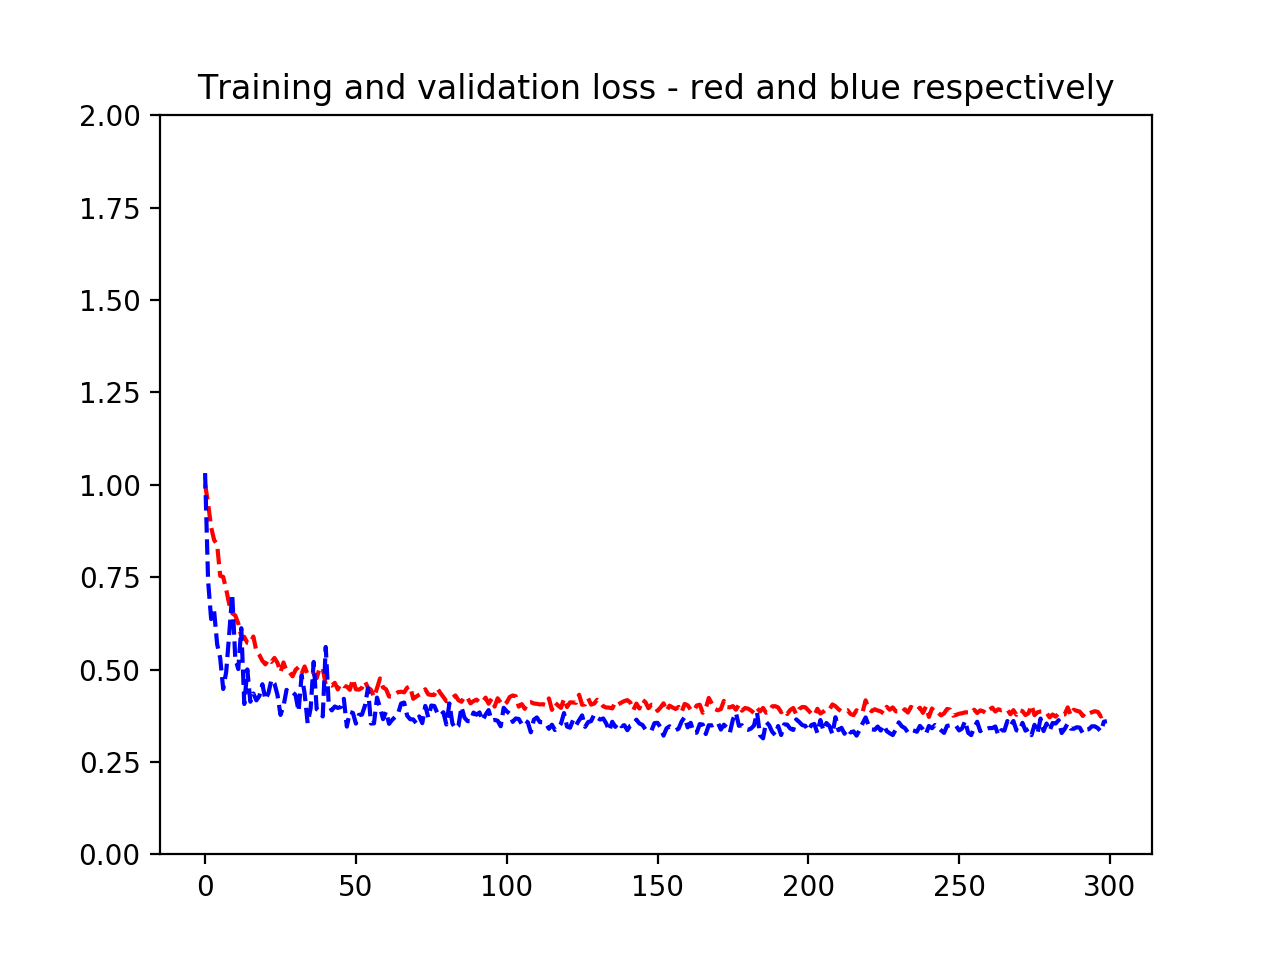

<IPython.core.display.Javascript object>


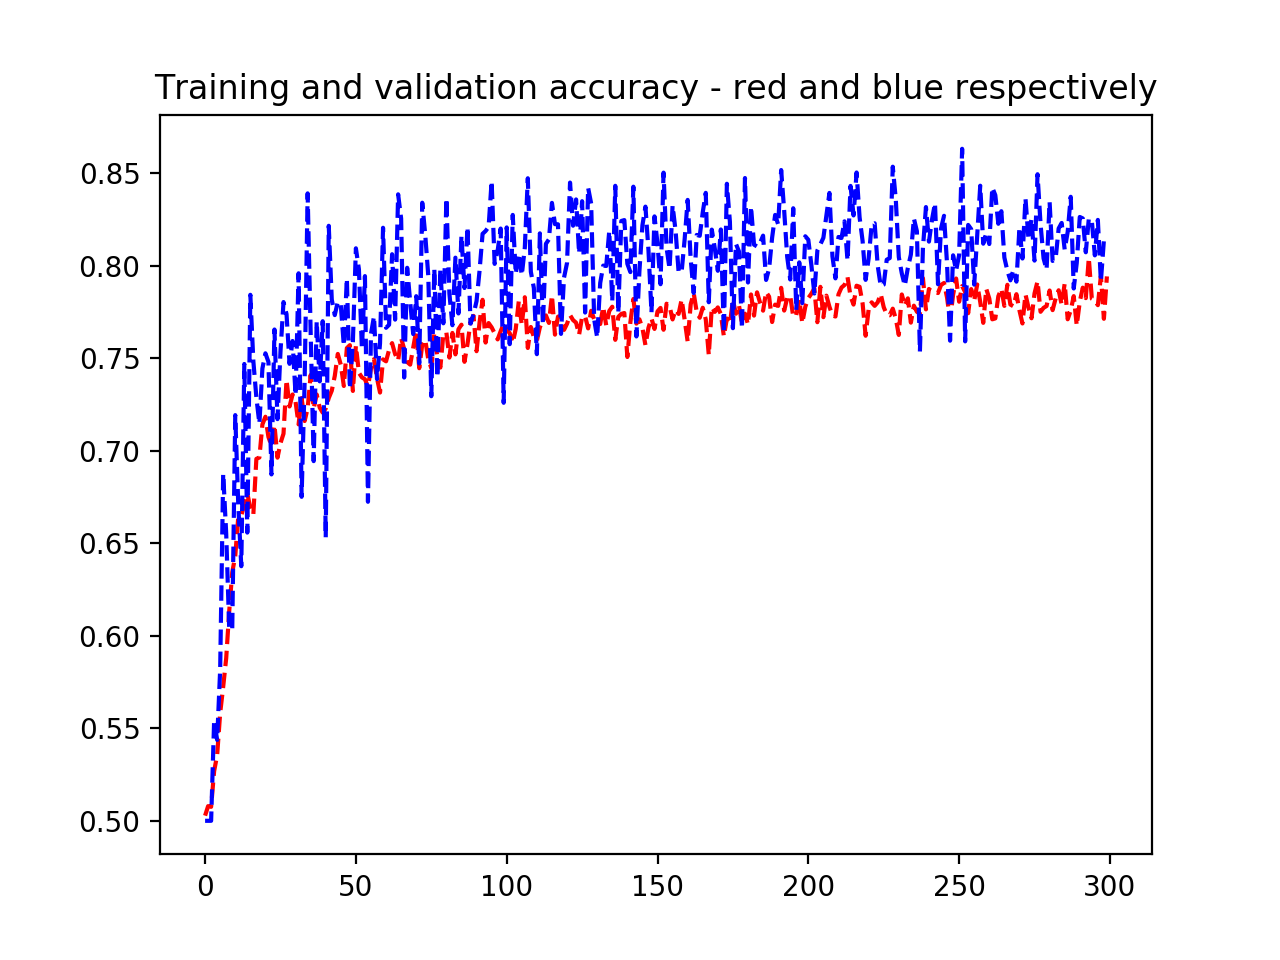

done


In [3]:
saved_dir = '../saved/IMPRS_hdf5_volume_AllDAPI_noise/0710_173648'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [4]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                m = torch.nn.Softmax(dim=0)
                print("prediction percentages")
                print(m(output.cpu()[0]))
                print(all_true[i])
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [5]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/6 [00:00<?, ?it/s]

Tesla K80


/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]

prediction percentages
tensor([0.0173, 0.9827])
1
prediction percentages
tensor([0.0420, 0.9580])
1


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]

num test images = 340
loss = 0.4484
my_metric = 0.7853
f1 = 0.8404
balanced_accuracy = 0.7954
precision = 0.9439
recall = 0.7853
My_metric is accuracy
Confusion matrix, without normalization
[[ 80  54]
 [ 19 187]]


<IPython.core.display.Javascript object>


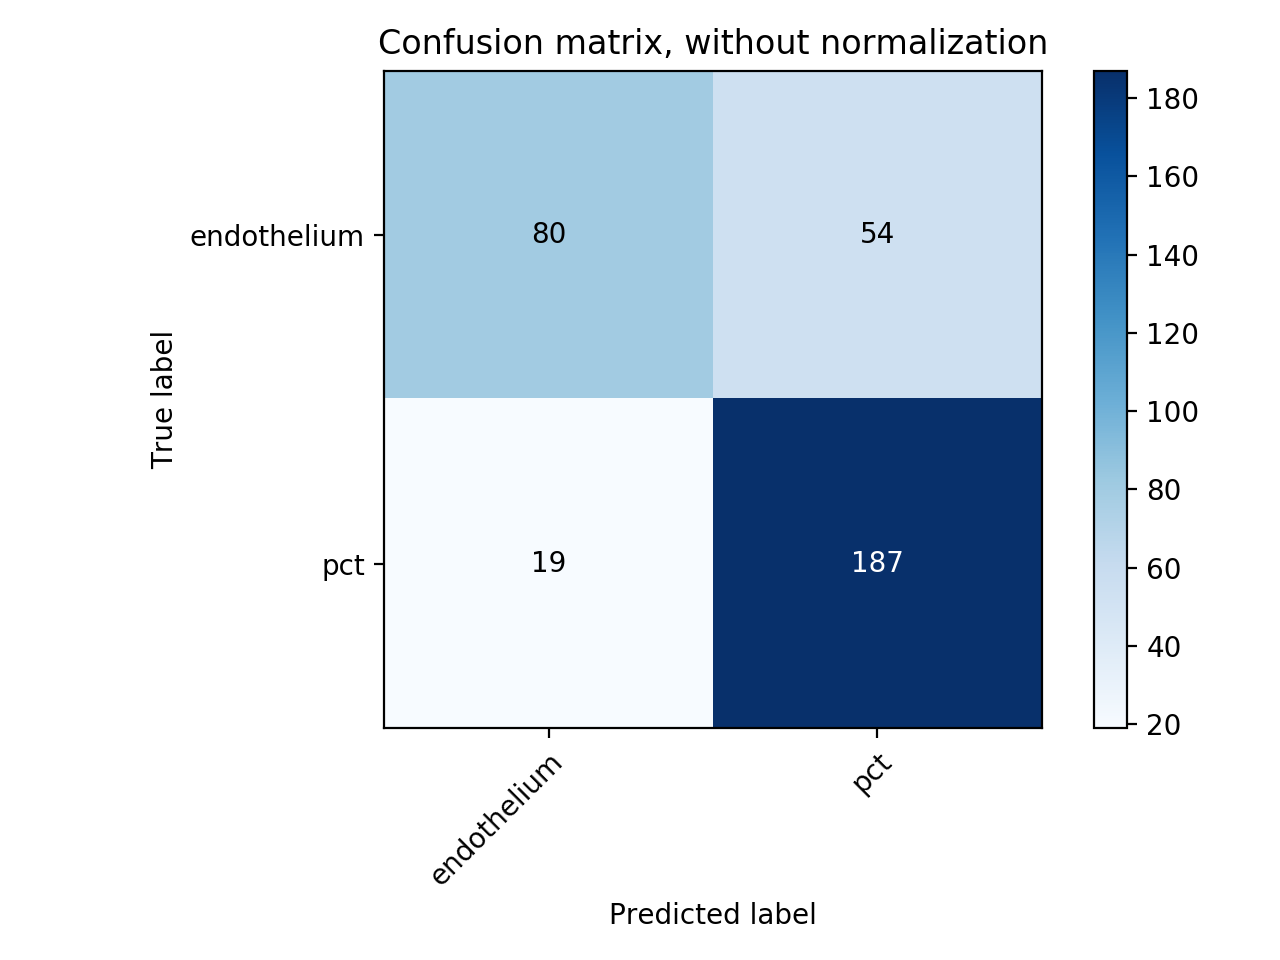

In [8]:
#Test
main2(config, resume)
